In [237]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
import skbio
from matplotlib.backends.backend_pdf import PdfPages 
from matplotlib import pylab
import os
from collections import OrderedDict
import scipy as sp

In [18]:
def unique(seq, idfun=None): 
   # order preserving
    if idfun is None:
        def idfun(x): return x
    seen = {}
    result = []
    for item in seq:
        if item != np.nan:
            marker = idfun(item)
            if marker in seen: continue
            seen[marker] = 1
            result.append(item)
    return result

In [ ]:
def bhatta ( data1,  data2):
    # calculate mean of hist1
    d1 =  np.mean(data1);

    # calculate mean of hist2
    d2 = np.mean(data2);

    # calculate score
    score = 0;
    for i in range(8):
        score += math.sqrt( hist1[i] * hist2[i] );
    # print h1_,h2_,score;
    score = math.sqrt( 1 - ( 1 / math.sqrt(h1_*h2_*8*8) ) * score );
    return score;

In [19]:
otu = pd.read_csv("all_filtered_otu_table.csv", index_col=0).transpose()
metadata= pd.read_csv("sample_metadata.csv", index_col=0)

In [20]:
seq_freq_filtered_by_patient_abundance = pd.read_csv("all_filtered_otu_table.csv", index_col=0).transpose().drop(["ndc432", "ndc442"])

In [21]:
seq_freq_filtered_by_patient = pd.read_csv("all_filtered_otu_table_counts.csv", index_col=0).transpose().drop(["ndc432", "ndc442"])

In [22]:
# for every patient, filter out seq vars with only one count (important for analysis of # seq vars in each patient)
seq_freq_filtered_by_patient = seq_freq_filtered_by_patient.copy()
seq_freq_filtered_by_patient=seq_freq_filtered_by_patient.replace(1,0)

In [23]:
genus_abundance = pd.read_csv("abundances_by_tax_level_relfreq/Genus_otu_table.csv", index_col=0).transpose().drop(["ndc432", "ndc442"])
genus = pd.read_csv("abundances_by_tax_level_counts/Genus_otu_table.csv", index_col=0).transpose().drop(["ndc432", "ndc442"])

In [24]:
genus_filtered_by_patient = genus.copy()
genus_filtered_by_patient=genus_filtered_by_patient.replace(1,0)

In [25]:
 set(seq_freq_filtered_by_patient_abundance.columns) - set(seq_freq_filtered_by_patient.columns) 

set()

### Engraftment

In [26]:
seq_var_dict = {} #dict where keys are patient ids and values are lists of indices representing seq vars that are in 
                    #the corresponding donor but not in the patient originally, where the first list is direct and the second pma
for i in seq_freq_filtered_by_patient.index:
    if metadata.loc[i, "timepoint"] == "Pre-FMT":
        seq_var_dict[metadata.loc[i, "person_id"]] = [list(set(list(seq_freq_filtered_by_patient.loc[metadata.loc[i, "direct_donor_fmt_id"]].nonzero()[0]))-set(list(seq_freq_filtered_by_patient.loc[i].nonzero()[0]))),list(set(list(seq_freq_filtered_by_patient.loc[metadata.loc[i, "pma_donor_fmt_id"]].nonzero()[0]))-set(list(seq_freq_filtered_by_patient.loc[i].nonzero()[0])))]

In [27]:
seq_var_dict = {} #dict where keys are patient ids and values are lists of indices representing seq vars that are in 
                    #the corresponding donor but not in the patient originally, where the first list is direct and the second pma
for i in seq_freq_filtered_by_patient.index:
    if metadata.loc[i, "timepoint"] == "Pre-FMT":
        seq_var_dict[metadata.loc[i, "person_id"]] = [list(set(list(seq_freq_filtered_by_patient.loc[metadata.loc[i, "direct_donor_fmt_id"]].nonzero()[0]))-set(list(seq_freq_filtered_by_patient.loc[i].nonzero()[0]))),list(set(list(seq_freq_filtered_by_patient.loc[metadata.loc[i, "pma_donor_fmt_id"]].nonzero()[0]))-set(list(seq_freq_filtered_by_patient.loc[i].nonzero()[0])))]

In [46]:
metadata.head()

pma speedvac donor_v_patient anaerobic_proc patient_sex  patient_age  \
ndc415  NaN      yes         patient            NaN        male         88.0   
ndc421  NaN      yes         patient            NaN        male         88.0   
ndc422  NaN       no         patient            NaN        male         88.0   
ndc423  NaN       no         patient            NaN        male         88.0   
ndc428  NaN       no         patient            NaN        male         88.0   

        donor_fmt_num anaerobic_fmt timepoint  donor_num  person_id  \
ndc415          131.0     Anaerobic   Pre-FMT        NaN        140   
ndc421          131.0     Anaerobic   4 weeks        NaN        140   
ndc422          131.0     Anaerobic   10 days        NaN        140   
ndc423          131.0     Anaerobic    3 days        NaN        140   
ndc428          131.0     Anaerobic   8 weeks        NaN        140   

        patient_num direct_donor_fmt_id pma_donor_fmt_id    fmt_sample  
ndc415        140.0              ndc408           ndc469  0131-0081-36  
ndc421        140.0              ndc408           ndc469  0131-0081-36  
ndc422        140.0              ndc408           ndc469  0131-0081-36  
ndc423        140.0              ndc408           ndc469  0131-0081-36  
ndc428        140.0              ndc408           ndc469  0131-0081-36

In [196]:
donor1=[] #500 - An:143, A:146
donor2=[] #485 - An:141, 159, A:176
donor3=[] #131 - An: 140, 167, A: 154, 160, 163, 178
donor_dict = {131:"Donor 1", 485:"Donor 2", 500:"Donor 3"}
engraftment_summary_df = pd.DataFrame(columns=["donor","patient","timepoint", "direct/pma", "count", "freq","abundance", "aerobic"])
with PdfPages("engraftment_timeseries.pdf") as pp:
    for patient, donor_seqs in seq_var_dict.items():
        donor_seqs.append(set(donor_seqs[0])-set(donor_seqs[1]))
        engraftment_df = pd.DataFrame(columns=["timepoint", "direct/pma", "count", "freq","abundance"])
       
        for i, timepoint in enumerate(["3 days", "10 days", "4 weeks", "8 weeks"]):
            
            try:

                #sample_id of sample corresponding to the given patient and timepoint
                sample_id = metadata.index[(metadata["person_id"] == patient) & (metadata["timepoint"] == timepoint)][0]
                donor = donor_dict[int(metadata.loc[sample_id, "donor_fmt_num"])]
                #list of indices of seq vars from direct and pma-processed donor samples that also show up in patient at different timepoints

#                 direct = list(set(donor_seqs[0]) & set(list(seq_freq_filtered_by_patient.loc[sample_id].nonzero()[0])))
#                 pma = list(set(donor_seqs[1]) & set(list(seq_freq_filtered_by_patient.loc[sample_id].nonzero()[0])))
#                 direct_pma = list(set(donor_seqs[2]) & set(list(seq_freq_filtered_by_patient.loc[sample_id].nonzero()[0])))
                
                direct = list(set(donor_seqs[0]) & set(seq_freq_filtered_by_patient.loc[sample_id].nonzero()[0]))
                pma = list(set(donor_seqs[1]) & set(seq_freq_filtered_by_patient.loc[sample_id].nonzero()[0]))
                direct_pma = list(set(donor_seqs[2]) & set(seq_freq_filtered_by_patient.loc[sample_id].nonzero()[0]))
 
                direct_abundance = 0
                pma_abundance = 0
                direct_pma_abundance = 0
                
                for d in direct:
                    direct_abundance += seq_freq_filtered_by_patient_abundance.loc[sample_id,seq_freq_filtered_by_patient_abundance.columns[d]]
                for p in pma:
                    pma_abundance += seq_freq_filtered_by_patient_abundance.loc[sample_id,seq_freq_filtered_by_patient.columns[p]]    
                for dp in direct_pma:
                    direct_pma_abundance += seq_freq_filtered_by_patient_abundance.loc[sample_id,seq_freq_filtered_by_patient.columns[dp]]  
                aerobic = metadata.loc[sample_id, "anaerobic_fmt"]
                num_patient_seq_var = np.count_nonzero(seq_freq_filtered_by_patient.loc[sample_id].values)
                engraftment_df = engraftment_df.append({"timepoint":timepoint, "direct/pma":"direct", "count":len(direct), "freq":len(direct)/num_patient_seq_var, "abundance":direct_abundance}, ignore_index=True)
                engraftment_df = engraftment_df.append({"timepoint":timepoint, "direct/pma":"pma", "count":len(pma), "freq":len(pma)/num_patient_seq_var, "abundance":pma_abundance}, ignore_index=True)
                engraftment_df = engraftment_df.append({"timepoint":timepoint, "direct/pma":"direct-pma", "count":len(direct_pma), "freq":len(direct_pma)/num_patient_seq_var, "abundance":direct_pma_abundance}, ignore_index=True)
                engraftment_summary_df = engraftment_summary_df.append({"donor":donor, "patient":patient,"timepoint":timepoint, "direct/pma":"direct", "count":len(direct), "freq":len(direct)/num_patient_seq_var, "abundance":direct_abundance, "aerobic":aerobic}, ignore_index=True)
                engraftment_summary_df = engraftment_summary_df.append({"donor":donor, "patient":patient,"timepoint":timepoint, "direct/pma":"pma", "count":len(pma), "freq":len(pma)/num_patient_seq_var, "abundance":pma_abundance,"aerobic":aerobic}, ignore_index=True)
                

            #missing timepoints
            except Exception as e:
                print(e)
        if metadata.loc[sample_id, "donor_fmt_num"] == 500:
            donor1.append([engraftment_df, int(patient), metadata.loc[sample_id,"anaerobic_fmt"]])
        elif metadata.loc[sample_id, "donor_fmt_num"] == 485:
            donor2.append([engraftment_df, int(patient), metadata.loc[sample_id,"anaerobic_fmt"]])
        else:
            donor3.append([engraftment_df, int(patient), metadata.loc[sample_id,"anaerobic_fmt"]])
        ax1 = sns.barplot(x="timepoint", y="count", hue="direct/pma",data = engraftment_df)
        ax1.set_title("Patient: {} Donor: {} {}".format(int(patient), int(metadata.loc[sample_id,"donor_fmt_num"]), metadata.loc[sample_id,"anaerobic_fmt"]))
        ax1.set_ylabel("total # donor seq vars in patient")
        pp.savefig()
        plt.close()
        
        ax2 = sns.barplot(x="timepoint", y="abundance", hue="direct/pma",data = engraftment_df)
        ax2.set_title("Patient: {} Donor: {} {}".format(int(patient), int(metadata.loc[sample_id,"donor_fmt_num"]), metadata.loc[sample_id,"anaerobic_fmt"]))
        ax2.set_ylabel("total relative abundance of donor seq vars in patient")
        pp.savefig()
        plt.close()



index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


In [48]:
fig, ax = plt.subplots()
with PdfPages("engraftment_timeseries_donorordered.pdf") as pp:
    for a in donor1:
        ax = sns.barplot(x="timepoint", y="count", hue="direct/pma",data = a[0])
        ax.set_title("Patient: {} Donor: {} {}".format(a[1], 500, a[2]))
        ax.set_ylabel("total # donor seq vars in patient")
        pp.savefig()
        plt.close()
    for b in donor2:
        ax = sns.barplot(x="timepoint", y="count", hue="direct/pma",data = b[0])
        ax.set_title("Patient: {} Donor: {} {}".format(b[1], 485, b[2]))
        ax.set_ylabel("total # donor seq vars in patient")
        pp.savefig()
        plt.close()
    for c in donor3:
        ax = sns.barplot(x="timepoint", y="count", hue="direct/pma",data = c[0])
        ax.set_title("Patient: {} Donor: {} {}".format(c[1], 131, c[2]))
        ax.set_ylabel("total # donor seq vars in patient")
        pp.savefig()
        plt.close()
    for a in donor1:
        ax = sns.barplot(x="timepoint", y="abundance", hue="direct/pma",data = a[0])
        ax.set_title("Patient: {} Donor: {} {}".format(a[1], 500, a[2]))
        ax.set_ylabel("total relative abundance of donor seq vars in patient")
        pp.savefig()
        plt.close()
    for b in donor2:
        ax = sns.barplot(x="timepoint", y="abundance", hue="direct/pma",data = b[0])
        ax.set_title("Patient: {} Donor: {} {}".format(b[1], 485, b[2]))
        ax.set_ylabel("total relative abundance of donor seq vars in patient")
        pp.savefig()
        plt.close()
    for c in donor3:
        ax = sns.barplot(x="timepoint", y="abundance", hue="direct/pma",data = c[0])
        ax.set_title("Patient: {} Donor: {} {}".format(c[1], 131, c[2]))
        ax.set_ylabel("total relative abundance of donor seq vars in patient")
        pp.savefig()
        plt.close()

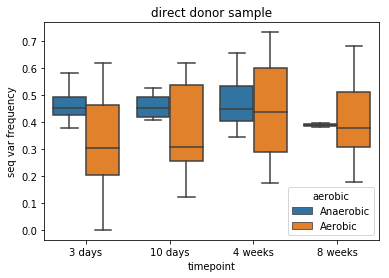

In [49]:
ax = sns.boxplot(x="timepoint", y="freq", hue="aerobic", data=engraftment_summary_df[engraftment_summary_df['direct/pma']=="direct"])
plt.xticks(plt.xticks()[0], ["3 days", "10 days", "4 weeks", "8 weeks"])
ax.set_ylabel("seq var frequency")
ax.set_title("direct donor sample")
plt.show()

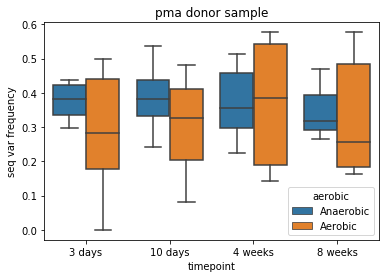

In [50]:
ax = sns.boxplot(x="timepoint", y="freq", hue="aerobic", data=engraftment_summary_df[engraftment_summary_df['direct/pma']=="pma"])
plt.xticks(plt.xticks()[0], ["3 days", "10 days", "4 weeks", "8 weeks"])
ax.set_ylabel("seq var frequency")
ax.set_title("pma donor sample")
plt.show()

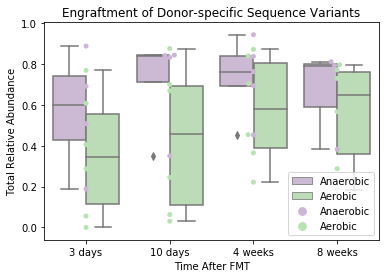

In [194]:
ax = sns.boxplot(x="timepoint", y="abundance", hue="aerobic", palette="PRGn",data=engraftment_summary_df[engraftment_summary_df['direct/pma']=="direct"])
sns.swarmplot(x="timepoint", y="abundance", hue="aerobic",palette="PRGn",data=engraftment_summary_df[engraftment_summary_df['direct/pma']=="direct"])
leg = ax.axes.get_legend()
leg.set_title("")
plt.xticks(plt.xticks()[0], ["3 days", "10 days", "4 weeks", "8 weeks"])
ax.set_ylabel("Total Relative Abundance")
ax.set_xlabel("Time After FMT")
ax.set_title("Engraftment of Donor-specific Sequence Variants")
plt.show()

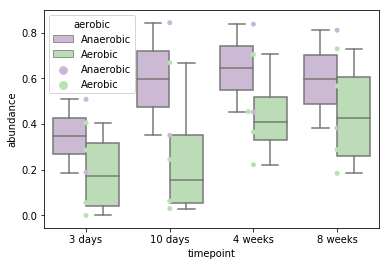

In [80]:
ax = sns.boxplot(x="timepoint", y="abundance", hue="aerobic", palette="PRGn",data=engraftment_summary_df[(engraftment_summary_df['direct/pma']=="direct")&(engraftment_summary_df['donor']==131)])
sns.swarmplot(x="timepoint", y="abundance", hue="aerobic",palette="PRGn",data=engraftment_summary_df[(engraftment_summary_df['direct/pma']=="direct")&(engraftment_summary_df['donor']==131)])
leg = ax.axes.get_legend()
leg.set_title("")
plt.xticks(plt.xticks()[0], ["3 days", "10 days", "4 weeks", "8 weeks"])
ax.set_ylabel("Total Relative Abundance")
ax.set_xlabel("Time After FMT")
ax.set_title("Engraftment of Donor-specific Sequence Variants Donor 131")
plt.show()

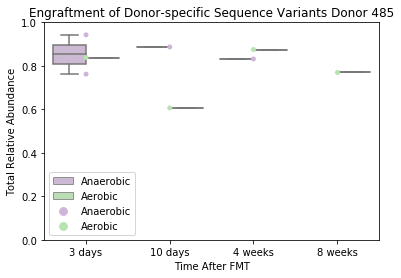

In [127]:
ax = sns.boxplot(x="timepoint", y="abundance", hue="aerobic", palette="PRGn",data=engraftment_summary_df[(engraftment_summary_df['direct/pma']=="direct")&(engraftment_summary_df['donor']==485)])
sns.swarmplot(x="timepoint", y="abundance", hue="aerobic",palette="PRGn",data=engraftment_summary_df[(engraftment_summary_df['direct/pma']=="direct")&(engraftment_summary_df['donor']==485)])
leg = ax.axes.get_legend()
leg.set_title("")
plt.xticks(plt.xticks()[0], ["3 days", "10 days", "4 weeks", "8 weeks"])
ax.set_ylabel("Total Relative Abundance")
ax.set_xlabel("Time After FMT")
ax.set_title("Engraftment of Donor-specific Sequence Variants Donor 485")
plt.ylim([0, 1])
plt.show()

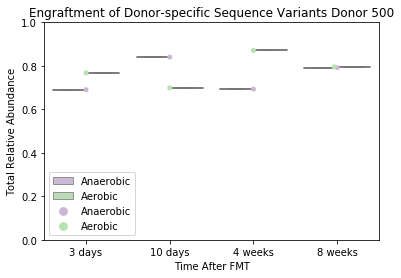

In [128]:
ax = sns.boxplot(x="timepoint", y="abundance", hue="aerobic", palette="PRGn",data=engraftment_summary_df[(engraftment_summary_df['direct/pma']=="direct")&(engraftment_summary_df['donor']==500)])
sns.swarmplot(x="timepoint", y="abundance", hue="aerobic",palette="PRGn",data=engraftment_summary_df[(engraftment_summary_df['direct/pma']=="direct")&(engraftment_summary_df['donor']==500)])
leg = ax.axes.get_legend()
leg.set_title("")
plt.xticks(plt.xticks()[0], ["3 days", "10 days", "4 weeks", "8 weeks"])
ax.set_ylabel("Total Relative Abundance")
ax.set_xlabel("Time After FMT")
ax.set_title("Engraftment of Donor-specific Sequence Variants Donor 500")
plt.ylim([0,1])
plt.show()

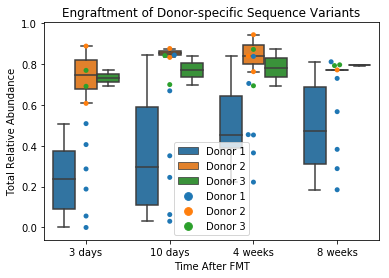

In [197]:
ax = sns.boxplot(x="timepoint", y="abundance", hue="donor", data=engraftment_summary_df[engraftment_summary_df['direct/pma']=="direct"])
sns.swarmplot(x="timepoint", y="abundance", hue="donor",data=engraftment_summary_df[engraftment_summary_df['direct/pma']=="direct"])
leg = ax.axes.get_legend()
leg.set_title("")
plt.xticks(plt.xticks()[0], ["3 days", "10 days", "4 weeks", "8 weeks"])
ax.set_ylabel("Total Relative Abundance")
ax.set_xlabel("Time After FMT")
ax.set_title("Engraftment of Donor-specific Sequence Variants")
plt.show()

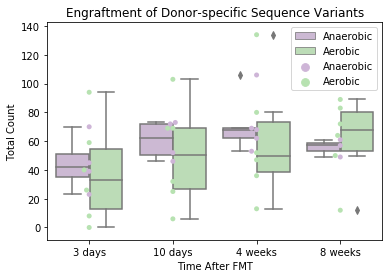

In [203]:
engraftment_summary_df["count"] = engraftment_summary_df["count"].astype(int)
ax = sns.boxplot(x="timepoint", y="count", hue="aerobic", palette="PRGn",data=engraftment_summary_df[engraftment_summary_df['direct/pma']=="direct"])
sns.swarmplot(x="timepoint", y="count", hue="aerobic",palette="PRGn",data=engraftment_summary_df[engraftment_summary_df['direct/pma']=="direct"])
plt.xticks(plt.xticks()[0], ["3 days", "10 days", "4 weeks", "8 weeks"])
ax.set_ylabel("Total Count")
leg = ax.axes.get_legend()
leg.set_title("")
ax.set_xlabel("Time After FMT")
ax.set_title("Engraftment of Donor-specific Sequence Variants")
plt.show()

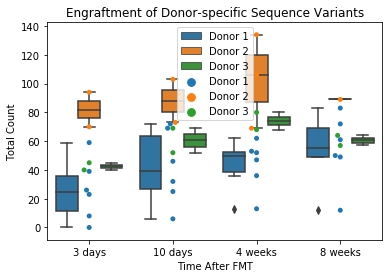

In [204]:
engraftment_summary_df["count"] = engraftment_summary_df["count"].astype(int)
ax = sns.boxplot(x="timepoint", y="count", hue="donor", data=engraftment_summary_df[engraftment_summary_df['direct/pma']=="direct"])
sns.swarmplot(x="timepoint", y="count", hue="donor",data=engraftment_summary_df[engraftment_summary_df['direct/pma']=="direct"])
plt.xticks(plt.xticks()[0], ["3 days", "10 days", "4 weeks", "8 weeks"])
ax.set_ylabel("Total Count")
leg = ax.axes.get_legend()
ax.set_xlabel("Time After FMT")
ax.set_title("Engraftment of Donor-specific Sequence Variants")
leg.set_title("")
plt.show()

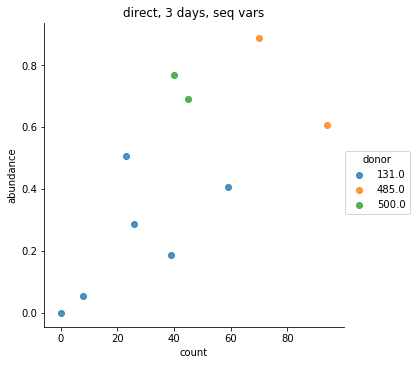

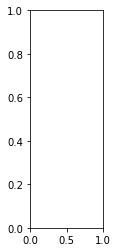

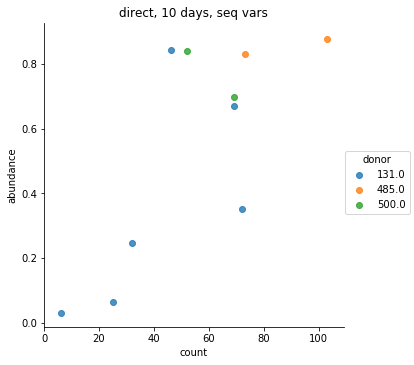

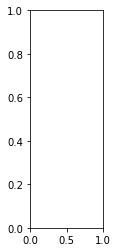

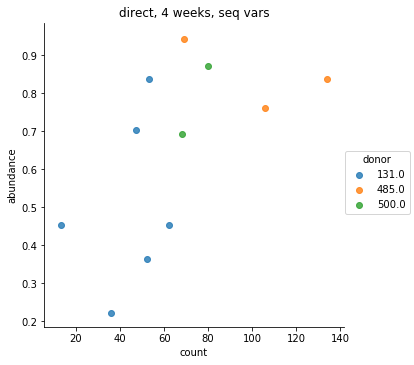

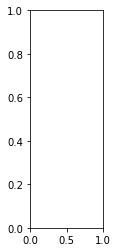

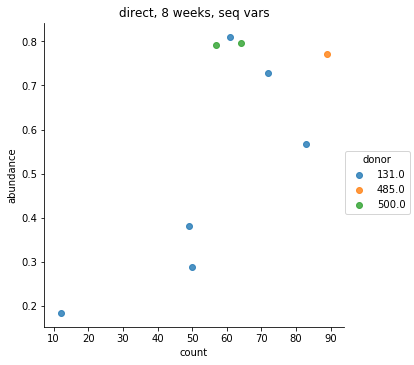

In [52]:
#abundance vs counts
sns.lmplot(x="count", y="abundance", hue="donor", data=engraftment_summary_df[(engraftment_summary_df['direct/pma']=="direct") & (engraftment_summary_df['timepoint']=="3 days")], fit_reg=False)
plt.title("direct, 3 days, seq vars")
plt.show()
plt.subplot(142)
sns.lmplot(x="count", y="abundance", hue="donor", data=engraftment_summary_df[(engraftment_summary_df['direct/pma']=="direct") & (engraftment_summary_df['timepoint']=="10 days")], fit_reg=False)
plt.title("direct, 10 days, seq vars")
plt.show()
plt.subplot(143)
sns.lmplot(x="count", y="abundance", hue="donor", data=engraftment_summary_df[(engraftment_summary_df['direct/pma']=="direct") & (engraftment_summary_df['timepoint']=="4 weeks")], fit_reg=False)
plt.title("direct, 4 weeks, seq vars")
plt.show()
plt.subplot(144)
sns.lmplot(x="count", y="abundance", hue="donor", data=engraftment_summary_df[(engraftment_summary_df['direct/pma']=="direct") & (engraftment_summary_df['timepoint']=="8 weeks")], fit_reg=False)
plt.title("direct, 8 weeks, seq vars")
plt.show()

## Comparing donor differences and aerobic/anaerobic differences w/ Bhattacharyya distances

In [83]:
engraftment_summary_df_direct = engraftment_summary_df[engraftment_summary_df['direct/pma']=="direct"]

In [123]:
def distance_calc(data1, data2):
    if np.sqrt(np.std(data1)*np.std(data2)) > 0:
        std = np.sqrt(np.std(data1)*np.std(data2))
    else:
        std = 1
    return np.abs(np.mean(data1)-np.mean(data2))

In [124]:
bhattacharrya_df = pd.DataFrame(columns=["timepoint", "aerobic", "donor12", "donor23", "donor13"])
for timepoint in unique(engraftment_summary_df_direct.timepoint):
    df_time = engraftment_summary_df_direct[engraftment_summary_df_direct["timepoint"]==timepoint]
    aerobic_abundance = list(df_time[df_time["aerobic"]=="Aerobic"].abundance)
    anaerobic_abundance = list(df_time[df_time["aerobic"]=="Anaerobic"].abundance)
    donor1 = list(df_time[df_time["donor"]==131].abundance)
    donor2 = list(df_time[df_time["donor"]==485].abundance)
    donor3 = list(df_time[df_time["donor"]==500].abundance)
    
    aerobic_dist = distance_calc(aerobic_abundance, anaerobic_abundance)
    donor_dist12 = distance_calc(donor1, donor2)
    donor_dist23 = distance_calc(donor3, donor2)
    donor_dist13 = distance_calc(donor1, donor3)
    bhattacharrya_df = bhattacharrya_df.append({"timepoint":timepoint, "aerobic": aerobic_dist, "donor12":donor_dist12, "donor23":donor_dist23, "donor13":donor_dist13}, ignore_index=True)
    

In [125]:
bhattacharrya_df

timepoint   aerobic   donor12   donor23   donor13
0    3 days  0.214465  0.506323  0.017620  0.488703
1   10 days  0.286424  0.486677  0.083685  0.402991
2   4 weeks  0.161642  0.341992  0.065751  0.276241
3   8 weeks  0.105744  0.277177  0.023011  0.300188

In [122]:
bhattacharrya_df

timepoint   aerobic   donor12   donor23    donor13
0    3 days  0.804860  3.184419  0.238648   5.831348
1   10 days  1.083800  6.031495  2.130917   2.764707
2   4 weeks  0.806166  2.768108  0.810406   2.040950
3   8 weeks  0.486348  0.277177  0.023011  14.319164

In [186]:
ttest_df = pd.DataFrame(columns=["timepoint", "distance", "samples_compared"])
for timepoint in unique(engraftment_summary_df_direct.timepoint):
    df_time = engraftment_summary_df_direct[engraftment_summary_df_direct["timepoint"]==timepoint]
    aerobic_abundance = list(df_time[df_time["aerobic"]=="Aerobic"].abundance)
    anaerobic_abundance = list(df_time[df_time["aerobic"]=="Anaerobic"].abundance)
    donor1 = list(df_time[df_time["donor"]==131].abundance)
    donor2 = list(df_time[df_time["donor"]==485].abundance)
    donor3 = list(df_time[df_time["donor"]==500].abundance)
    
    aerobic_dist = sp.stats.ttest_ind(aerobic_abundance, anaerobic_abundance)[0]
    donor_dist12 = sp.stats.ttest_ind(donor1, donor2)[0]
    donor_dist23 = sp.stats.ttest_ind(donor2, donor3)[0]
    donor_dist13 = sp.stats.ttest_ind(donor1, donor3)[0]
    if timepoint == "8 weeks":
        donor_dist23 = np.abs(np.mean(donor3) - np.mean(donor2))
        donor_dist12 = np.abs(np.mean(donor1) - np.mean(donor2))
    ttest_df = ttest_df.append({"timepoint":timepoint, "distance":aerobic_dist, "samples_compared":"Aerobic-Anaerobic"}, ignore_index=True)
    ttest_df = ttest_df.append({"timepoint":timepoint, "distance":donor_dist12, "samples_compared":"Donor1-Donor2"}, ignore_index=True)
    ttest_df = ttest_df.append({"timepoint":timepoint, "distance":donor_dist23, "samples_compared":"Donor2-Donor3"}, ignore_index=True)
    ttest_df = ttest_df.append({"timepoint":timepoint, "distance":donor_dist13, "samples_compared":"Donor1-Donor3"}, ignore_index=True)

/Users/vivzhong/anaconda/envs/intro_dl/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/vivzhong/anaconda/envs/intro_dl/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


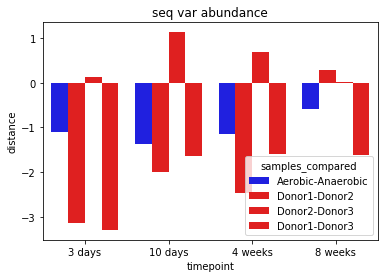

In [187]:
sns.barplot(x="timepoint", y="distance", hue="samples_compared",palette={"Aerobic-Anaerobic":"blue", "Donor1-Donor2":"red", "Donor2-Donor3":"red","Donor1-Donor3":"red"},data=ttest_df)
plt.title("seq var abundance")
plt.show()

In [235]:
ttest_average_df = pd.DataFrame(columns=["timepoint", "distance", "factor"])
for timepoint in unique(engraftment_summary_df_direct.timepoint):
    df_time = engraftment_summary_df_direct[engraftment_summary_df_direct["timepoint"]==timepoint]
    aerobic_abundance = list(df_time[df_time["aerobic"]=="Aerobic"].abundance)
    anaerobic_abundance = list(df_time[df_time["aerobic"]=="Anaerobic"].abundance)
    donor1 = list(df_time[df_time["donor"]==131].abundance)
    donor2 = list(df_time[df_time["donor"]==485].abundance)
    donor3 = list(df_time[df_time["donor"]==500].abundance)
    
    aerobic_dist = sp.stats.ttest_ind(aerobic_abundance, anaerobic_abundance)[0]
    donor_dist12 = sp.stats.ttest_ind(donor1, donor2)[0]
    donor_dist23 = sp.stats.ttest_ind(donor2, donor3)[0]
    donor_dist13 = sp.stats.ttest_ind(donor1, donor3)[0]

    ttest_average_df = ttest_average_df.append({"timepoint":timepoint, "distance":np.abs(aerobic_dist), "factor":"Oxygen Exposure"}, ignore_index=True)
    ttest_average_df = ttest_average_df.append({"timepoint":timepoint, "distance":np.abs(donor_dist12), "factor":"Donor"}, ignore_index=True)
    ttest_average_df = ttest_average_df.append({"timepoint":timepoint, "distance":np.abs(donor_dist23), "factor":"Donor"}, ignore_index=True)
    ttest_average_df = ttest_average_df.append({"timepoint":timepoint, "distance":np.abs(donor_dist13), "factor":"Donor"}, ignore_index=True)

/Users/vivzhong/anaconda/envs/intro_dl/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/vivzhong/anaconda/envs/intro_dl/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


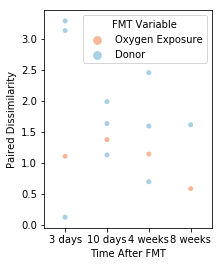

In [244]:
ax = sns.swarmplot(x="timepoint", y="distance", hue="factor", palette="RdBu", data=ttest_average_df)
plt.title("")
leg = ax.axes.get_legend()
leg.set_title("FMT Variable")
plt.ylabel("Paired Dissimilarity")
plt.xlabel("Time After FMT")
plt.show()
plt.figure(figsize=(3,5))

In [190]:
ttest_df = pd.DataFrame(columns=["timepoint", "distance", "samples_compared"])
for timepoint in unique(engraftment_summary_df_direct.timepoint):
    df_time = engraftment_summary_df_direct[engraftment_summary_df_direct["timepoint"]==timepoint]
    aerobic_count = list(df_time[df_time["aerobic"]=="Aerobic"]["count"])
    anaerobic_count = list(df_time[df_time["aerobic"]=="Anaerobic"]["count"])
    donor1 = list(df_time[df_time["donor"]==131]["count"])
    donor2 = list(df_time[df_time["donor"]==485]["count"])
    donor3 = list(df_time[df_time["donor"]==500]["count"])
    
    aerobic_dist = sp.stats.ttest_ind(aerobic_count, anaerobic_count)[0]
    donor_dist12 = sp.stats.ttest_ind(donor1, donor2)[0]
    donor_dist23 = sp.stats.ttest_ind(donor2, donor3)[0]
    donor_dist13 = sp.stats.ttest_ind(donor1, donor3)[0]

    ttest_df = ttest_df.append({"timepoint":timepoint, "distance":aerobic_dist, "samples_compared":"Aerobic-Anaerobic"}, ignore_index=True)
    ttest_df = ttest_df.append({"timepoint":timepoint, "distance":donor_dist12, "samples_compared":"Donor1-Donor2"}, ignore_index=True)
    ttest_df = ttest_df.append({"timepoint":timepoint, "distance":donor_dist23, "samples_compared":"Donor2-Donor3"}, ignore_index=True)
    ttest_df = ttest_df.append({"timepoint":timepoint, "distance":donor_dist13, "samples_compared":"Donor1-Donor3"}, ignore_index=True)

/Users/vivzhong/anaconda/envs/intro_dl/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/vivzhong/anaconda/envs/intro_dl/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


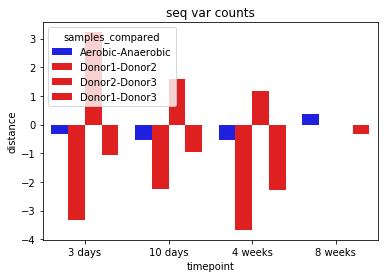

In [191]:
sns.barplot(x="timepoint", y="distance", hue="samples_compared", palette={"Aerobic-Anaerobic":"blue", "Donor1-Donor2":"red", "Donor2-Donor3":"red","Donor1-Donor3":"red"},data=ttest_df)
plt.title("seq var counts")
plt.show()

In [214]:
ttest_average_df = pd.DataFrame(columns=["timepoint", "distance", "factor"])
for timepoint in unique(engraftment_summary_df_direct.timepoint):
    df_time = engraftment_summary_df_direct[engraftment_summary_df_direct["timepoint"]==timepoint]
    aerobic_abundance = list(df_time[df_time["aerobic"]=="Aerobic"]["count"])
    anaerobic_abundance = list(df_time[df_time["aerobic"]=="Anaerobic"]["count"])
    donor1 = list(df_time[df_time["donor"]==131]["count"])
    donor2 = list(df_time[df_time["donor"]==485]["count"])
    donor3 = list(df_time[df_time["donor"]==500]["count"])
    
    aerobic_dist = sp.stats.ttest_ind(aerobic_abundance, anaerobic_abundance)[0]
    donor_dist12 = sp.stats.ttest_ind(donor1, donor2)[0]
    donor_dist23 = sp.stats.ttest_ind(donor2, donor3)[0]
    donor_dist13 = sp.stats.ttest_ind(donor1, donor3)[0]

    ttest_average_df = ttest_average_df.append({"timepoint":timepoint, "distance":np.abs(aerobic_dist), "factor":"Oxygen Exposure"}, ignore_index=True)
    ttest_average_df = ttest_average_df.append({"timepoint":timepoint, "distance":np.abs(donor_dist12), "factor":"Donor"}, ignore_index=True)
    ttest_average_df = ttest_average_df.append({"timepoint":timepoint, "distance":np.abs(donor_dist23), "factor":"Donor"}, ignore_index=True)
    ttest_average_df = ttest_average_df.append({"timepoint":timepoint, "distance":np.abs(donor_dist13), "factor":"Donor"}, ignore_index=True)

/Users/vivzhong/anaconda/envs/intro_dl/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/vivzhong/anaconda/envs/intro_dl/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


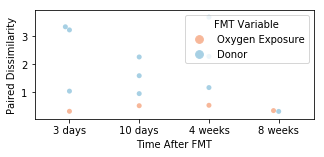

In [233]:
ax = sns.swarmplot(x="timepoint", y="distance", hue="factor", palette="RdBu", data=ttest_average_df)
plt.title("")
leg = ax.axes.get_legend()
leg.set_title("FMT Variable")
plt.ylabel("Paired Dissimilarity")
plt.xlabel("Time After FMT")
plt.show()
plt.figure(figsize=(5,2))

### Engraftment, collapsed to genus level

In [64]:
donor1=[] #500 - An:143, A:146
donor2=[] #485 - An:141, 159, A:176
donor3=[] #131 - An: 140, 167, A: 154, 160, 163, 178

spores = []
genus_dict = {} #dict where keys are patient ids and values are lists of indices representing genera that are in 
                    #the corresponding donor but not in the patient originally, where the first list is direct and the second pma
for i in genus.index:
    if metadata.loc[i, "timepoint"] == "Pre-FMT":
        genus_dict[metadata.loc[i, "person_id"]] = [list(set(list(genus.loc[metadata.loc[i, "direct_donor_fmt_id"]].nonzero()[0]))-set(list(genus.loc[i].nonzero()[0]))),list(set(list(genus.loc[metadata.loc[i, "pma_donor_fmt_id"]].nonzero()[0]))-set(list(genus.loc[i].nonzero()[0])))]
genus_engraftment_summary_df = pd.DataFrame(columns=["donor","timepoint", "direct/pma", "count", "freq","abundance", "aerobic"])
with PdfPages("engraftment_timeseries_genus.pdf") as pp:
    for patient, donor_seqs in genus_dict.items():
        donor_seqs.append(set(donor_seqs[0])-set(donor_seqs[1]))
        genus_engraftment_df = pd.DataFrame(columns=["timepoint", "direct/pma", "count", "freq","abundance"])
        for i, timepoint in enumerate(["3 days", "10 days", "4 weeks", "8 weeks"]):  
            try:
                #sample_id of sample corresponding to the given patient and timepoint
                sample_id = metadata.index[(metadata["person_id"] == patient) & (metadata["timepoint"] == timepoint)][0]
                #list of indices of seq vars from direct and pma-processed donor samples that also show up in patient at different timepoints

                direct = list(set(donor_seqs[0]) & set(genus_filtered_by_patient.loc[sample_id].nonzero()[0]))
                pma = list(set(donor_seqs[1]) & set(genus_filtered_by_patient.loc[sample_id].nonzero()[0]))
                direct_pma = list(set(donor_seqs[2]) & set(genus_filtered_by_patient.loc[sample_id].nonzero()[0]))
                [spores.append(genus.columns[spore]) for spore in direct_pma]
                direct_abundance = 0
                pma_abundance = 0
                direct_pma_abundance = 0
                for d in direct:
                    direct_abundance += genus_abundance.loc[sample_id,genus_abundance.columns[d]]
                for p in pma:
                    pma_abundance += genus_abundance.loc[sample_id,genus_abundance.columns[p]]    
                for dp in direct_pma:
                    direct_pma_abundance += genus_abundance.loc[sample_id,genus_abundance.columns[dp]]   
                
                aerobic = metadata.loc[sample_id, "anaerobic_fmt"]
                
                num_patient_genus = np.count_nonzero(genus.loc[sample_id].values)
                donor = metadata.loc[sample_id, "donor_fmt_num"]
                
                genus_engraftment_df = genus_engraftment_df.append({"timepoint":timepoint, "direct/pma":"direct", "count":len(direct), "freq":len(direct)/num_patient_genus, "abundance":direct_abundance}, ignore_index=True)
                genus_engraftment_df = genus_engraftment_df.append({"timepoint":timepoint, "direct/pma":"pma", "count":len(pma), "freq":len(pma)/num_patient_genus, "abundance":pma_abundance}, ignore_index=True)
                genus_engraftment_df = genus_engraftment_df.append({"timepoint":timepoint, "direct/pma":"direct-pma", "count":len(direct_pma), "freq":len(direct_pma)/num_patient_genus, "abundance":direct_pma_abundance}, ignore_index=True)
                genus_engraftment_summary_df = genus_engraftment_summary_df.append({"donor":donor,"timepoint":timepoint, "direct/pma":"direct", "count":len(direct), "freq":len(direct)/num_patient_genus, "abundance":direct_abundance, "aerobic":aerobic}, ignore_index=True)
                genus_engraftment_summary_df = genus_engraftment_summary_df.append({"donor":donor, "timepoint":timepoint, "direct/pma":"pma", "count":len(pma), "freq":len(pma)/num_patient_genus, "abundance":pma_abundance, "aerobic":aerobic}, ignore_index=True)

            #missing timepoints
            except Exception as e:
                print(e)
        if metadata.loc[sample_id, "donor_fmt_num"] == 500:
            donor1.append([genus_engraftment_df, int(patient), metadata.loc[sample_id,"anaerobic_fmt"]])
        elif metadata.loc[sample_id, "donor_fmt_num"] == 485:
            donor2.append([genus_engraftment_df, int(patient), metadata.loc[sample_id,"anaerobic_fmt"]])
        else:
            donor3.append([genus_engraftment_df, int(patient), metadata.loc[sample_id,"anaerobic_fmt"]])
        ax1 = sns.barplot(x="timepoint", y="count", hue="direct/pma",data = genus_engraftment_df)
        ax1.set_title("Patient: {} Donor: {} {}".format(int(patient), int(metadata.loc[sample_id,"donor_fmt_num"]), metadata.loc[sample_id,"anaerobic_fmt"]))
        ax1.set_ylabel("total # donor genera in patient")
        pp.savefig()
        plt.close()
        
        ax2 = sns.barplot(x="timepoint", y="abundance", hue="direct/pma",data = genus_engraftment_df)
        ax2.set_title("Patient: {} Donor: {} {}".format(int(patient), int(metadata.loc[sample_id,"donor_fmt_num"]), metadata.loc[sample_id,"anaerobic_fmt"]))
        ax2.set_ylabel("total relative abundance of donor genera in patient")
        pp.savefig()
        plt.close()




index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


In [38]:
fig, ax = plt.subplots()
with PdfPages("engraftment_timeseries_donorordered_genus.pdf") as pp:
    for a in donor1:
        ax = sns.barplot(x="timepoint", y="count", hue="direct/pma",data = a[0])
        ax.set_title("Patient: {} Donor: {} {}".format(a[1], 500, a[2]))
        ax.set_ylabel("total # donor genera in patient")
        pp.savefig()
        plt.close()
    for b in donor2:
        ax = sns.barplot(x="timepoint", y="count", hue="direct/pma",data = b[0])
        ax.set_title("Patient: {} Donor: {} {}".format(b[1], 485, b[2]))
        ax.set_ylabel("total # donor genera in patient")
        pp.savefig()
        plt.close()
    for c in donor3:
        ax = sns.barplot(x="timepoint", y="count", hue="direct/pma",data = c[0])
        ax.set_title("Patient: {} Donor: {} {}".format(c[1], 131, c[2]))
        ax.set_ylabel("total # donor genera in patient")
        pp.savefig()
        plt.close()
    for a in donor1:
        ax = sns.barplot(x="timepoint", y="abundance", hue="direct/pma",data = a[0])
        ax.set_title("Patient: {} Donor: {} {}".format(a[1], 500, a[2]))
        ax.set_ylabel("total relative abundance of donor genera in patient")
        pp.savefig()
        plt.close()
    for b in donor2:
        ax = sns.barplot(x="timepoint", y="abundance", hue="direct/pma",data = b[0])
        ax.set_title("Patient: {} Donor: {} {}".format(b[1], 485, b[2]))
        ax.set_ylabel("total relative abundance of donor genera in patient")
        pp.savefig()
        plt.close()
    for c in donor3:
        ax = sns.barplot(x="timepoint", y="abundance", hue="direct/pma",data = c[0])
        ax.set_title("Patient: {} Donor: {} {}".format(c[1], 131, c[2]))
        ax.set_ylabel("total relative abundance of donor genera in patient")
        pp.savefig()
        plt.close()

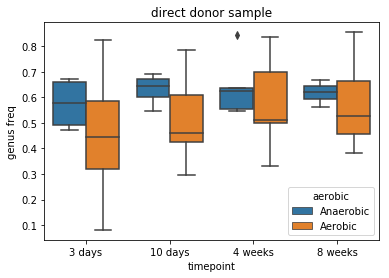

In [39]:
ax = sns.boxplot(x="timepoint", y="freq", hue="aerobic", data=genus_engraftment_summary_df[genus_engraftment_summary_df['direct/pma']=="direct"])
plt.xticks(plt.xticks()[0], ["3 days", "10 days", "4 weeks", "8 weeks"])
ax.set_ylabel("genus freq")
ax.set_title("Engraftment of Donor-specific Genera")
plt.show()

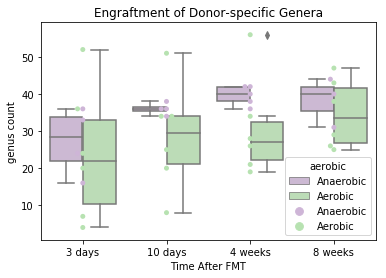

In [72]:
genus_engraftment_summary_df["count"] = genus_engraftment_summary_df["count"].astype(int)
ax = sns.boxplot(x="timepoint", y="count", hue="aerobic", palette="PRGn",data=genus_engraftment_summary_df[genus_engraftment_summary_df['direct/pma']=="direct"])
ax = sns.swarmplot(x="timepoint", y="count", hue="aerobic", palette="PRGn",data=genus_engraftment_summary_df[genus_engraftment_summary_df['direct/pma']=="direct"])
plt.xticks(plt.xticks()[0], ["3 days", "10 days", "4 weeks", "8 weeks"])
ax.set_ylabel("genus count")
ax.set_xlabel("Time After FMT")
ax.set_title("Engraftment of Donor-specific Genera")
plt.show()

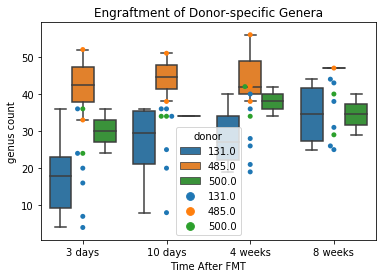

In [71]:
genus_engraftment_summary_df["count"] = genus_engraftment_summary_df["count"].astype(int)
ax = sns.boxplot(x="timepoint", y="count", hue="donor", data=genus_engraftment_summary_df[genus_engraftment_summary_df['direct/pma']=="direct"])
ax = sns.swarmplot(x="timepoint", y="count", hue="donor", data=genus_engraftment_summary_df[genus_engraftment_summary_df['direct/pma']=="direct"])
plt.xticks(plt.xticks()[0], ["3 days", "10 days", "4 weeks", "8 weeks"])
ax.set_ylabel("genus count")
ax.set_xlabel("Time After FMT")
ax.set_title("Engraftment of Donor-specific Genera")
plt.show()

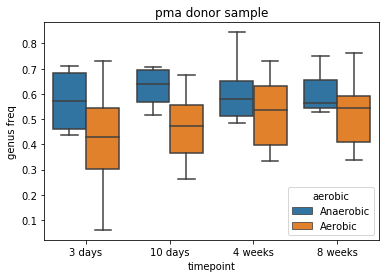

In [41]:
ax = sns.boxplot(x="timepoint", y="freq", hue="aerobic", data=genus_engraftment_summary_df[genus_engraftment_summary_df['direct/pma']=="pma"])
plt.xticks(plt.xticks()[0], ["3 days", "10 days", "4 weeks", "8 weeks"])
ax.set_ylabel("genus freq")
ax.set_title("pma donor sample")
plt.show()

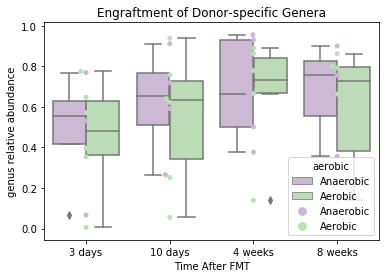

In [73]:

ax = sns.boxplot(x="timepoint", y="abundance", hue="aerobic", palette="PRGn",data=genus_engraftment_summary_df[genus_engraftment_summary_df['direct/pma']=="direct"])
ax = sns.swarmplot(x="timepoint", y="abundance", hue="aerobic", palette="PRGn",data=genus_engraftment_summary_df[genus_engraftment_summary_df['direct/pma']=="direct"])
plt.xticks(plt.xticks()[0], ["3 days", "10 days", "4 weeks", "8 weeks"])
ax.set_ylabel("genus relative abundance")
ax.set_xlabel("Time After FMT")
ax.set_title("Engraftment of Donor-specific Genera")
plt.show()

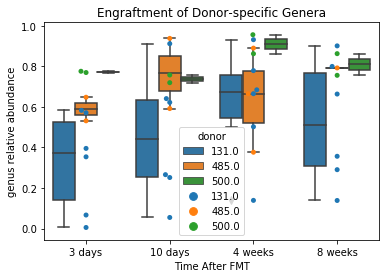

In [74]:

ax = sns.boxplot(x="timepoint", y="abundance", hue="donor", data=genus_engraftment_summary_df[genus_engraftment_summary_df['direct/pma']=="direct"])
ax = sns.swarmplot(x="timepoint", y="abundance", hue="donor", data=genus_engraftment_summary_df[genus_engraftment_summary_df['direct/pma']=="direct"])
plt.xticks(plt.xticks()[0], ["3 days", "10 days", "4 weeks", "8 weeks"])
ax.set_ylabel("genus relative abundance")
ax.set_xlabel("Time After FMT")
ax.set_title("Engraftment of Donor-specific Genera")
plt.show()

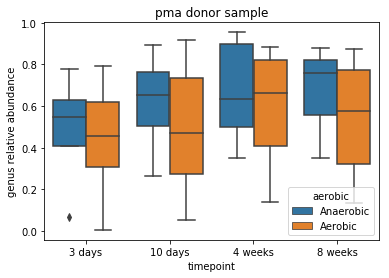

In [43]:
ax = sns.boxplot(x="timepoint", y="abundance", hue="aerobic", data=genus_engraftment_summary_df[genus_engraftment_summary_df['direct/pma']=="pma"])
plt.xticks(plt.xticks()[0], ["3 days", "10 days", "4 weeks", "8 weeks"])
ax.set_ylabel("genus relative abundance")
ax.set_title("pma donor sample")
plt.show()

In [44]:
genus_engraftment_pma_aerobic = genus_engraftment_pma[genus_engraftment_pma["aerobic"]=="Aerobic"]
all_aerobic_donor = set(genus_engraftment_pma_aerobic[genus_engraftment_pma_aerobic["donor_count"] >0].otu)
genus_engraftment_pma_anaerobic = genus_engraftment_pma[genus_engraftment_pma["aerobic"]=="Anaerobic"]
all_anaerobic_donor = set(genus_engraftment_pma_anaerobic[genus_engraftment_pma_anaerobic["donor_count"] >0].otu)

NameError: name 'genus_engraftment_pma' is not defined

In [ ]:
genus_engraftment_pma_aerobic = genus_engraftment_pma[genus_engraftment_pma["aerobic"]=="Aerobic"]
all_aerobic = set(genus_engraftment_pma_aerobic[genus_engraftment_pma_aerobic["count"] >0].otu)

In [ ]:
genus_engraftment_pma_anaerobic = genus_engraftment_pma[genus_engraftment_pma["aerobic"]=="Anaerobic"]
all_anaerobic = set(genus_engraftment_pma_anaerobic[genus_engraftment_pma_anaerobic["count"] >0].otu)

In [ ]:
only_in_aerobic = all_aerobic - all_anaerobic

In [ ]:
only_in_anaerobic = all_anaerobic - all_aerobic

In [ ]:
only_in_aerobic

In [ ]:
only_in_anaerobic

In [ ]:
in_both = all_aerobic & all_anaerobic

In [ ]:
in_both

### Engraftment of Specific Bugs by Donor
Timepoint after FMT (3 days, unless not available, in which case use 4 weeks)

In [ ]:
#donors
donors = [485, 500, 131]
with PdfPages("differential_genera_abundance_by_donor.pdf") as pp:
    for donor in donors:
        for dp in ["direct", "pma"]:
            df = genus_engraftment[(genus_engraftment["donor"] == donor) & (genus_engraftment["direct/pma"] == dp)]
            sns.barplot(x="otu", y="donor_abundance", hue="aerobic", data=df.sort_values(by="otu"))
            plt.xticks(rotation=90, fontsize=40)
            plt.yticks(fontsize=40)
            plt.legend(fontsize=40)
            plt.title("{} {}".format(donor, dp), fontsize=60)
            plt.show()
            plt.figure(figsize=(50,30))
#             pp.savefig()
#             plt.close()


        

In [ ]:
#patients
donors = [485, 500, 131]
with PdfPages("differential_genera_abundance_by_patient.pdf") as pp:
    for donor in donors:
        for dp in ["direct", "pma"]:
            df = genus_engraftment[(genus_engraftment["donor"] == donor) & (genus_engraftment["direct/pma"] == dp)]
            sns.barplot(x="otu", y="abundance", hue="aerobic", data=df.sort_values(by="otu"))
            plt.xticks(rotation=90, fontsize=40)
            plt.yticks(fontsize=40)
            plt.legend(fontsize=40)
            plt.title("{} {}".format(donor, dp), fontsize=60)
            plt.show()
            plt.figure(figsize=(50,30))
#             pp.savefig()
#             plt.close()

        

### Log-fold differences between anaerobic and aerobic by donor 

In [247]:
genus_engraftment_direct_averaged = genus_engraftment_direct.drop(['patient', 'direct/pma'], axis=1)
genus_engraftment_direct_averaged["count"] = genus_engraftment_direct_averaged['count'].astype(int)
genus_engraftment_direct_averaged = genus_engraftment_direct_averaged.groupby(['donor', 'aerobic', 'otu']).mean().reset_index()

In [248]:
genus_engraftment_direct_averaged["log_abundance"] = np.log(genus_engraftment_direct_averaged["abundance"])

/Users/vivzhong/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [249]:
def genus_engraftment_calculate_lfd(df):
    """
    df (DataFrame): columns are "donor", "aerobic", "otu", "abundance" (average of all patients for the same donor and FMT type), 
        "donor_abundance", "log_abundance" (patient)
    """
    genus_engraftment_lfd = pd.DataFrame(columns=["donor","otu", "lfd", "only"])
    for donor in df.donor.unique(): #every donor
        for otu in df[df["donor"] == donor].otu: #every otu
            try:
                anaerobic_id = df.index[(df["donor"] == donor) & (df["otu"] == otu) & (df["aerobic"] == "Anaerobic")][0]
                anaerobic = df.loc[anaerobic_id,"log_abundance"]
            except: 
                anaerobic = -np.inf
            try:
                aerobic_id = df.index[(df["donor"] == donor) & (df["otu"] == otu) & (df["aerobic"] == "Aerobic")][0]   
                aerobic = df.loc[aerobic_id,"log_abundance"]
            except:
                aerobic = -np.inf

            if aerobic == -np.inf and anaerobic == -np.inf:
                genus_engraftment_lfd = genus_engraftment_lfd.append({"donor":donor, "otu":otu, "lfd":np.nan, "only":np.nan}, ignore_index=True)
            elif aerobic == -np.inf:
                genus_engraftment_lfd = genus_engraftment_lfd.append({"donor":donor, "otu":otu, "lfd":np.nan, "only":"Anaerobic"}, ignore_index=True)
            elif anaerobic == -np.inf:
                genus_engraftment_lfd = genus_engraftment_lfd.append({"donor":donor, "otu":otu, "lfd":np.nan, "only":"Aerobic"}, ignore_index=True)
            else:
                lfd = anaerobic - aerobic
                genus_engraftment_lfd = genus_engraftment_lfd.append({"donor":donor, "otu":otu, "lfd":lfd, "only":np.nan}, ignore_index=True)
    return genus_engraftment_lfd

In [250]:
genus_engraftment_direct_lfd = genus_engraftment_calculate_lfd(genus_engraftment_direct_averaged)

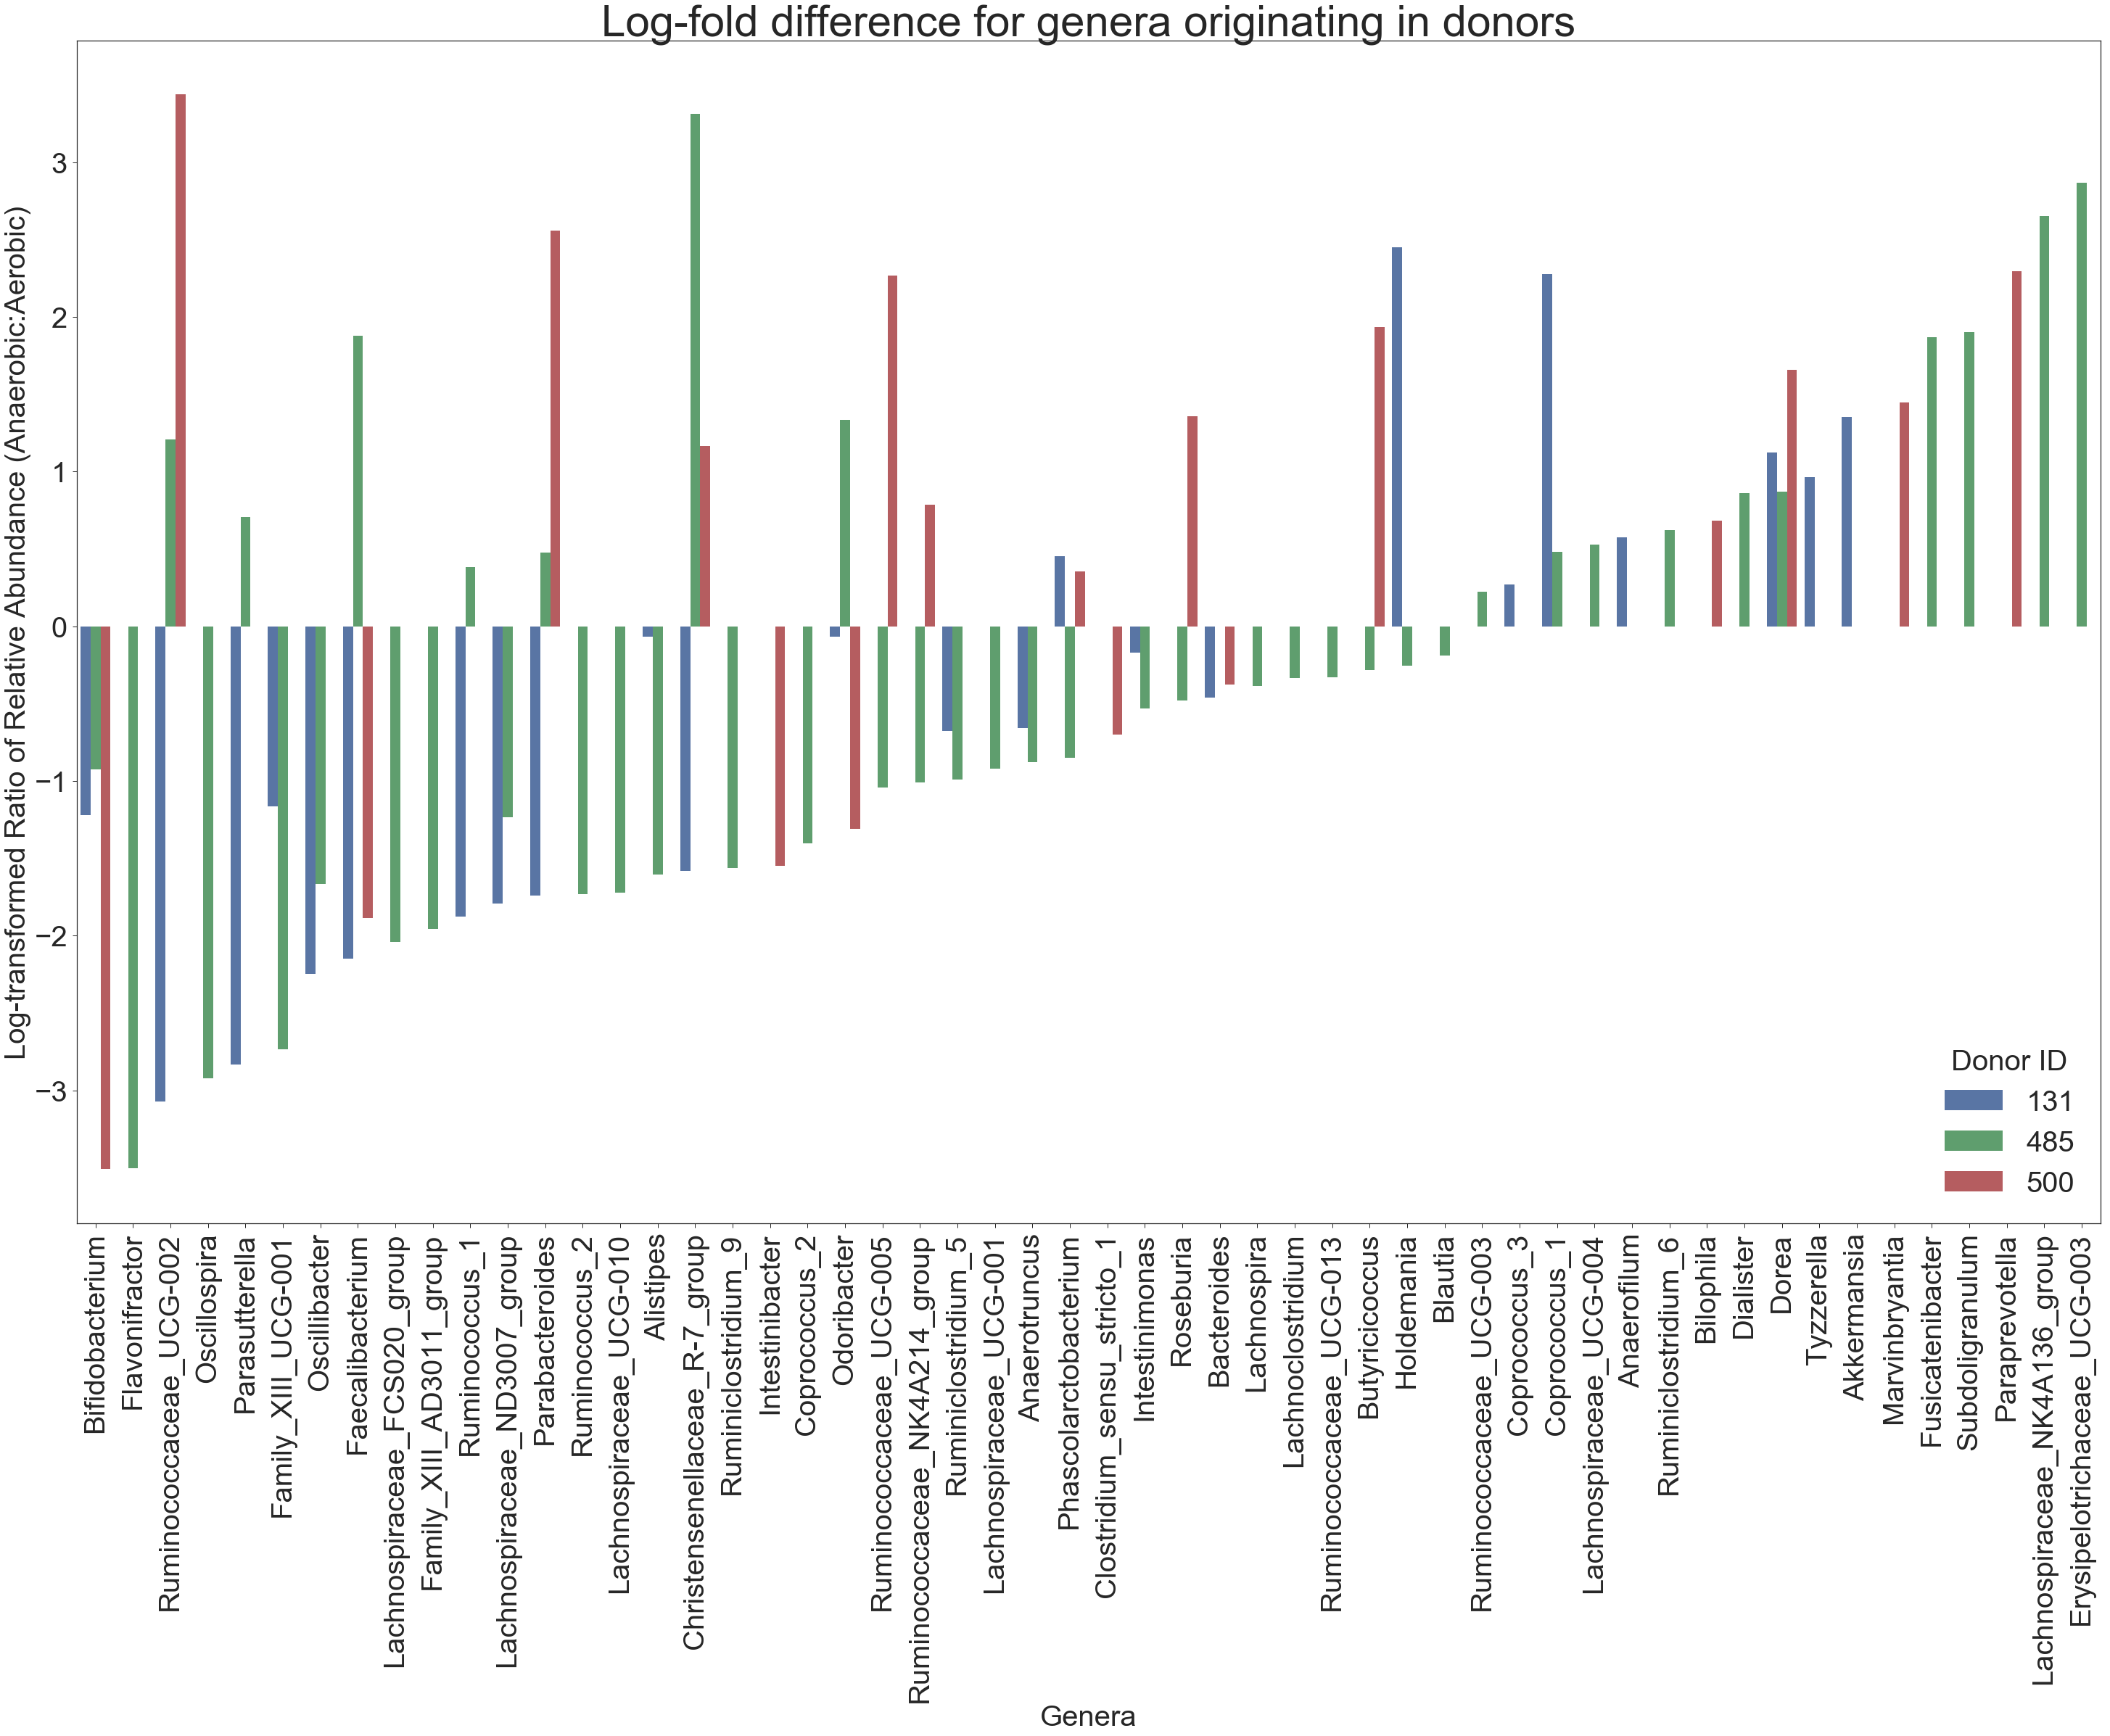

In [404]:
sns.barplot(x="otu", y="lfd", hue="donor",data=genus_engraftment_direct_lfd[pd.isnull(genus_engraftment_direct_lfd["lfd"])==False].sort_values(by="lfd"))
plt.xticks(rotation=90, fontsize=40)
plt.yticks(fontsize=40)
leg = plt.legend(fontsize=40, title="Donor ID")

leg.get_title().set_fontsize(40)
plt.title("Log-fold difference for genera originating in donors", fontsize=60)
plt.ylabel("Log-transformed Ratio of Relative Abundance (Anaerobic:Aerobic)", fontsize=40)
plt.xlabel("Genera", fontsize=40)
plt.show()
plt.figure(figsize=(50,30))

### In donor but no patient

In [252]:
genus_engraftment_pma_averaged = genus_engraftment_pma.drop(['patient', 'direct/pma'], axis=1)
genus_engraftment_pma_averaged["count"] = genus_engraftment_pma_averaged['count'].astype(int)


In [253]:
all_genus_engraftment_pma_all_donors_donor_only_averaged = genus_engraftment_pma_averaged[genus_engraftment_pma_averaged.index.isin(all_genus_engraftment_pma_all_donors_donor_only.index)]
all_genus_engraftment_pma_all_donors_donor_only_averaged = all_genus_engraftment_pma_all_donors_donor_only_averaged.groupby(['donor', 'aerobic', 'otu']).mean().reset_index()

In [254]:
all_genus_engraftment_pma_all_donors_donor_only_averaged["log_abundance"] = np.log(all_genus_engraftment_pma_all_donors_donor_only_averaged["abundance"])
all_genus_engraftment_pma_all_donors_donor_only_averaged_lfd = genus_engraftment_calculate_lfd(all_genus_engraftment_pma_all_donors_donor_only_averaged)

/Users/vivzhong/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [255]:
genus_engraftment_pma_lfd

donor                            otu       lfd       only
0     131                      Alistipes -0.064426        NaN
1     131                    Allisonella       NaN    Aerobic
2     131                  Anaerotruncus -0.655056        NaN
3     131                    Bacteroides -0.460343        NaN
4     131                Bifidobacterium -1.219630        NaN
5     131                 Butyricicoccus       NaN  Anaerobic
6     131  Christensenellaceae_R-7_group -1.582540        NaN
7     131    Clostridium_sensu_stricto_1       NaN        NaN
8     131                  Coprococcus_1  2.278156        NaN
9     131                  Coprococcus_2       NaN    Aerobic
10    131                  Coprococcus_3  0.268558        NaN
11    131      Defluviitaleaceae_UCG-011       NaN        NaN
12    131                          Dorea  1.125696        NaN
13    131    Erysipelotrichaceae_UCG-003       NaN  Anaerobic
14    131               Faecalibacterium -2.147074        NaN
15    131       Family_XIII_AD3011_group       NaN  Anaerobic
16    131            Family_XIII_UCG-001 -1.161670        NaN
17    131               Fusicatenibacter       NaN        NaN
18    131                Intestinibacter       NaN    Aerobic
19    131                 Intestinimonas -0.172060        NaN
20    131              Lachnoclostridium       NaN    Aerobic
21    131                    Lachnospira       NaN    Aerobic
22    131   Lachnospiraceae_AC2044_group       NaN        NaN
23    131   Lachnospiraceae_ND3007_group -1.789501        NaN
24    131  Lachnospiraceae_NK4A136_group       NaN    Aerobic
25    131        Lachnospiraceae_UCG-001       NaN    Aerobic
26    131        Lachnospiraceae_UCG-004       NaN    Aerobic
27    131        Lachnospiraceae_UCG-006       NaN        NaN
28    131        Lachnospiraceae_UCG-010       NaN        NaN
29    131                    Odoribacter -0.065494        NaN
..    ...                            ...       ...        ...
323   500             Methanobrevibacter       NaN  Anaerobic
324   500                    Odoribacter -1.308129        NaN
325   500                  Oscillibacter  0.494397        NaN
326   500                   Oscillospira       NaN        NaN
327   500                    Oxalobacter       NaN    Aerobic
328   500                Parabacteroides  2.559652        NaN
329   500                 Paraprevotella  2.295657        NaN
330   500                 Parasutterella       NaN    Aerobic
331   500          Phascolarctobacterium  0.354501        NaN
332   500                   Prevotella_9       NaN    Aerobic
333   500                     Romboutsia       NaN        NaN
334   500                      Roseburia  1.356420        NaN
335   500            Ruminiclostridium_5       NaN  Anaerobic
336   500            Ruminiclostridium_6       NaN        NaN
337   500            Ruminiclostridium_9       NaN  Anaerobic
338   500  Ruminococcaceae_NK4A214_group  0.786918        NaN
339   500        Ruminococcaceae_UCG-002  3.440096        NaN
340   500        Ruminococcaceae_UCG-003       NaN  Anaerobic
341   500        Ruminococcaceae_UCG-005  2.267624        NaN
342   500        Ruminococcaceae_UCG-007       NaN        NaN
343   500        Ruminococcaceae_UCG-010       NaN        NaN
344   500        Ruminococcaceae_UCG-011       NaN        NaN
345   500        Ruminococcaceae_UCG-013       NaN        NaN
346   500        Ruminococcaceae_UCG-014       NaN        NaN
347   500                 Ruminococcus_1       NaN        NaN
348   500                 Ruminococcus_2       NaN  Anaerobic
349   500                        Slackia       NaN        NaN
350   500                Subdoligranulum       NaN        NaN
351   500               Terrisporobacter       NaN        NaN
352   500                   Turicibacter       NaN        NaN

[353 rows x 4 columns]

In [256]:
genus_engraftment_pma_averaged = genus_engraftment_pma_averaged.groupby(['donor', 'aerobic', 'otu']).mean().reset_index()
genus_engraftment_pma_averaged["log_abundance"] = np.log(genus_engraftment_pma_averaged["abundance"])
genus_engraftment_pma_lfd = genus_engraftment_calculate_lfd(genus_engraftment_pma_averaged)

/Users/vivzhong/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


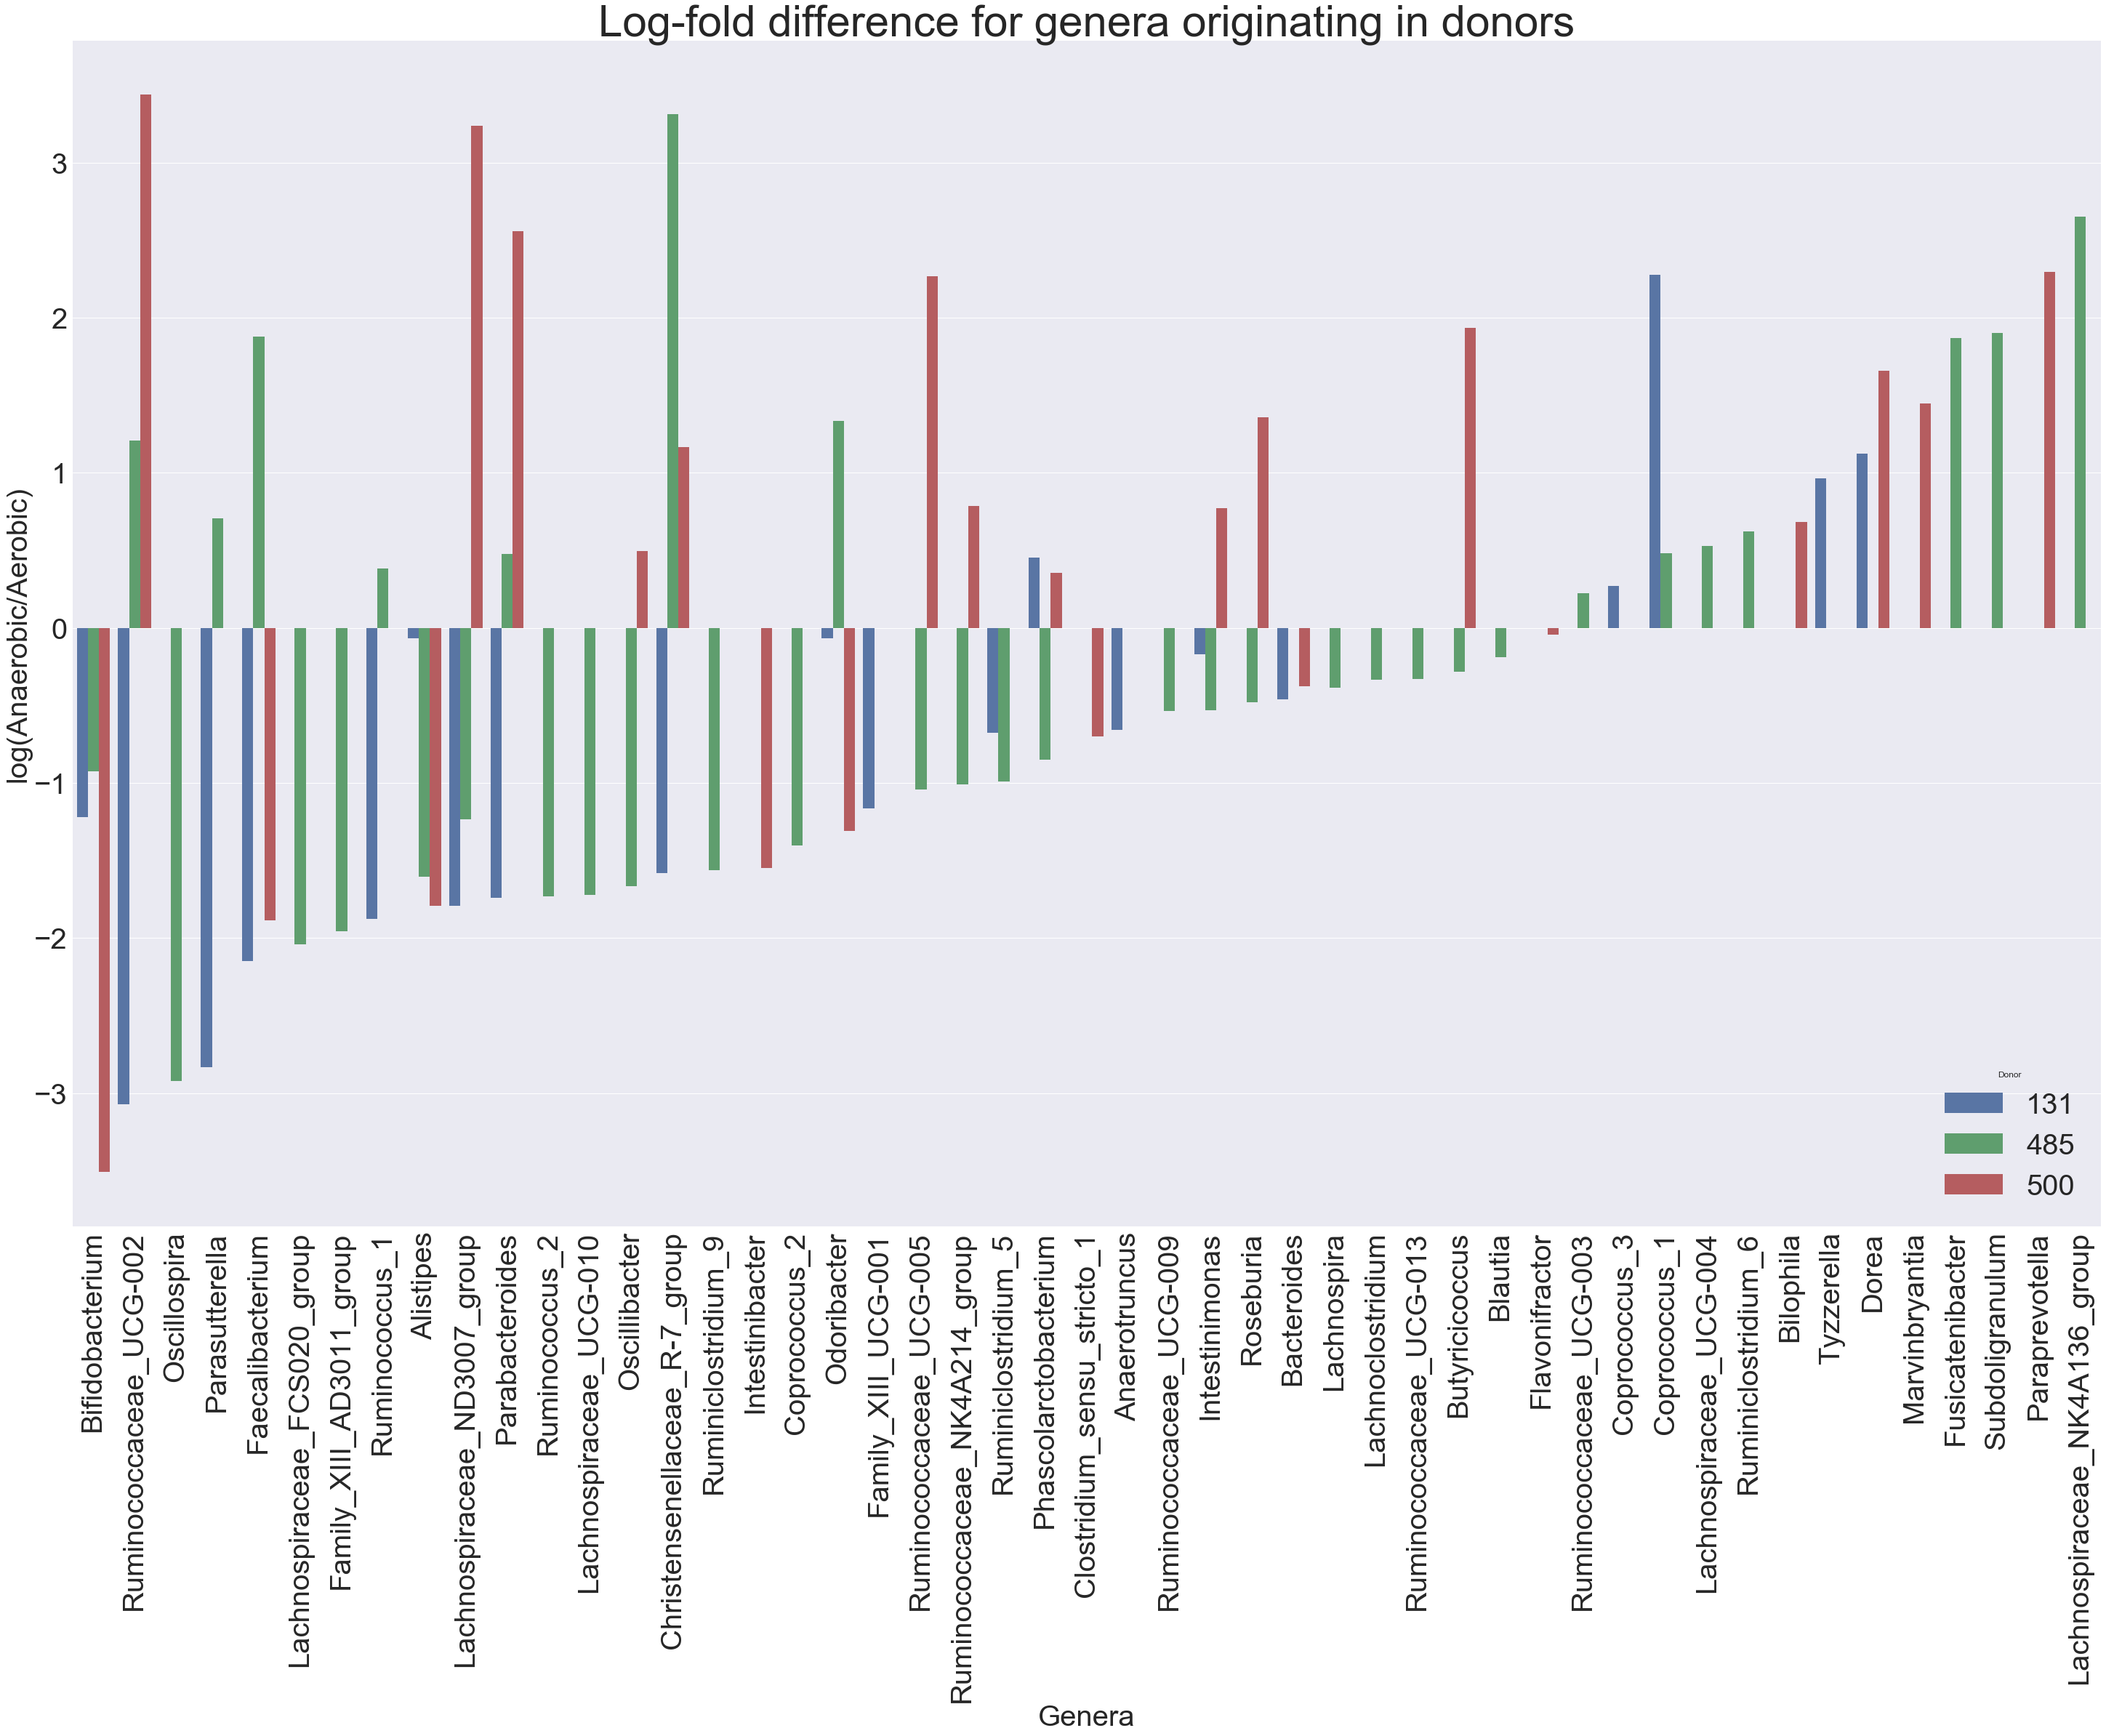

In [388]:
sns.barplot(x="otu", y="lfd", hue="donor", data=genus_engraftment_pma_lfd[pd.isnull(genus_engraftment_pma_averaged_lfd["lfd"])==False].sort_values(by="lfd"))
plt.xticks(rotation=90, fontsize=40)
plt.yticks(fontsize=40)
plt.legend(fontsize=40, title="Donor")
plt.xlabel("Genera", fontsize=40)
plt.title("Log-fold difference for genera originating in donors", fontsize=60)
plt.ylabel("log(Anaerobic/Aerobic)", fontsize=40)
plt.show()
plt.figure(figsize=(50,30))

#### Strains in Anaerobic vs Aerobic Donors

In [271]:
strains_in_anaerobic_donors = unique(genus_engraftment_anaerobic.index)

In [272]:
strains_in_aerobic_donors = unique(genus_engraftment_aerobic.index)

In [273]:
len(strains_in_aerobic_donors)

74

In [274]:
len(strains_in_anaerobic_donors)

83

In [275]:
genus_abundance.loc["ndc407"].index
    

Index(['Acetanaerobacterium', 'Acidaminococcus', 'Actinomyces',
       'Adlercreutzia', 'Akkermansia', 'Alistipes', 'Allisonella',
       'Anaerococcus', 'Anaerofilum', 'Anaerofustis',
       ...
       'Synergistes', 'Terrisporobacter', 'Trueperella', 'Turicibacter',
       'Tyzzerella', 'Tyzzerella_4', 'Varibaculum', 'Veillonella',
       'Victivallis', 'Weissella'],
      dtype='object', name='Genus', length=146)

In [276]:
def donor_composition(otu_table_counts, otu_table_abundance, metadata):

    donor_composition_df = pd.DataFrame(columns=["donor", "donor_sample","otu", "direct/pma", "count", "abundance", "aerobic"])
    donor_seqs = {} #dict where keys are patient ids and values are lists of indices representing seq vars that are in 
                    #the corresponding donor but not in the patient originally, where the first list is direct and the second pma
    for sample_id in otu_table_counts.index:
        if metadata.loc[sample_id, "donor_v_patient"] == "donor":            
            aerobic = metadata.loc[sample_id, "anaerobic_proc"]
            pma = metadata.loc[sample_id, "pma"]
            for otu in otu_table_abundance.loc[sample_id].index:
                count = otu_table_counts.loc[sample_id, otu]
                abundance = otu_table_abundance.loc[sample_id, otu]
                donor_composition_df = donor_composition_df.append({"donor":int(metadata.loc[sample_id, "person_id"]), "donor_sample":sample_id,"otu":otu,"direct/pma":pma, "count":count, "abundance":abundance, "aerobic":aerobic}, ignore_index=True)            
    return donor_composition_df




In [277]:
genus_donor_composition = donor_composition(genus_filtered_by_patient, genus_abundance, metadata)

In [153]:
genus_donor_composition.head()

NameError: name 'genus_donor_composition' is not defined

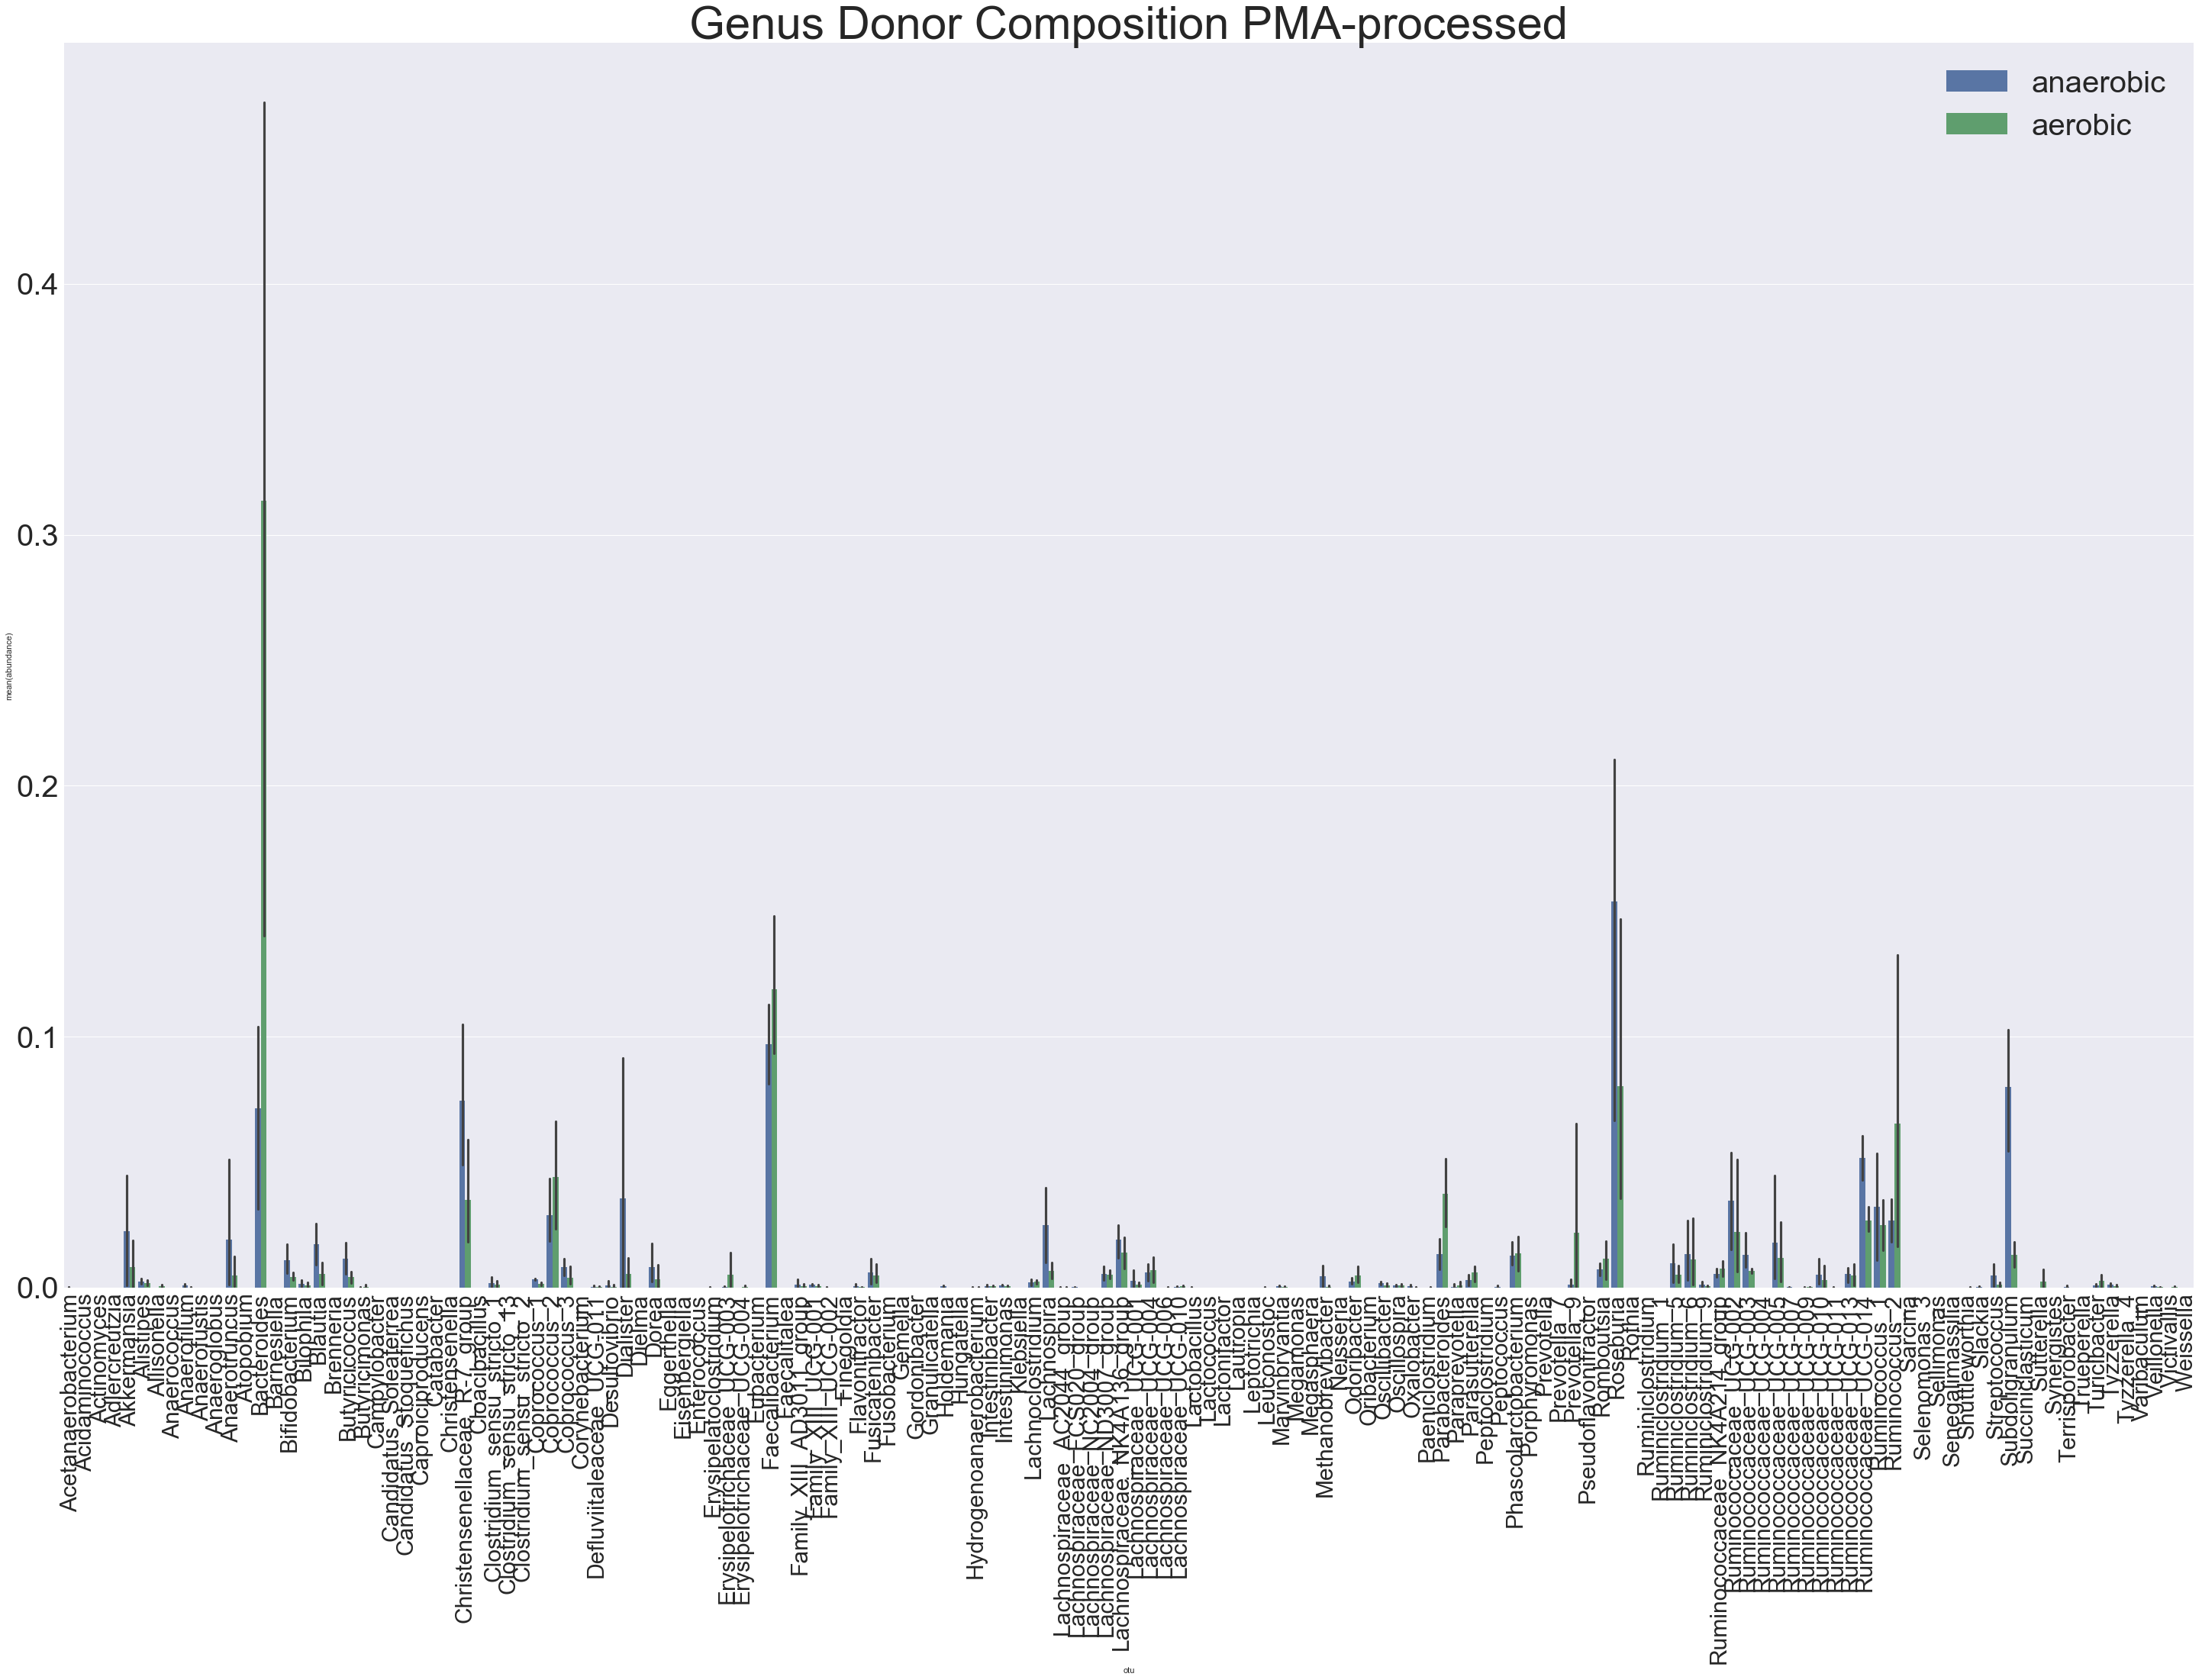

In [278]:
sns.barplot(x="otu", y="abundance", hue="aerobic", data=genus_donor_composition[genus_donor_composition["direct/pma"]=="pma"])
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=40)
plt.legend(fontsize=40)
plt.title("Genus Donor Composition PMA-processed", fontsize=60)
plt.show()
plt.figure(figsize=(50,30))



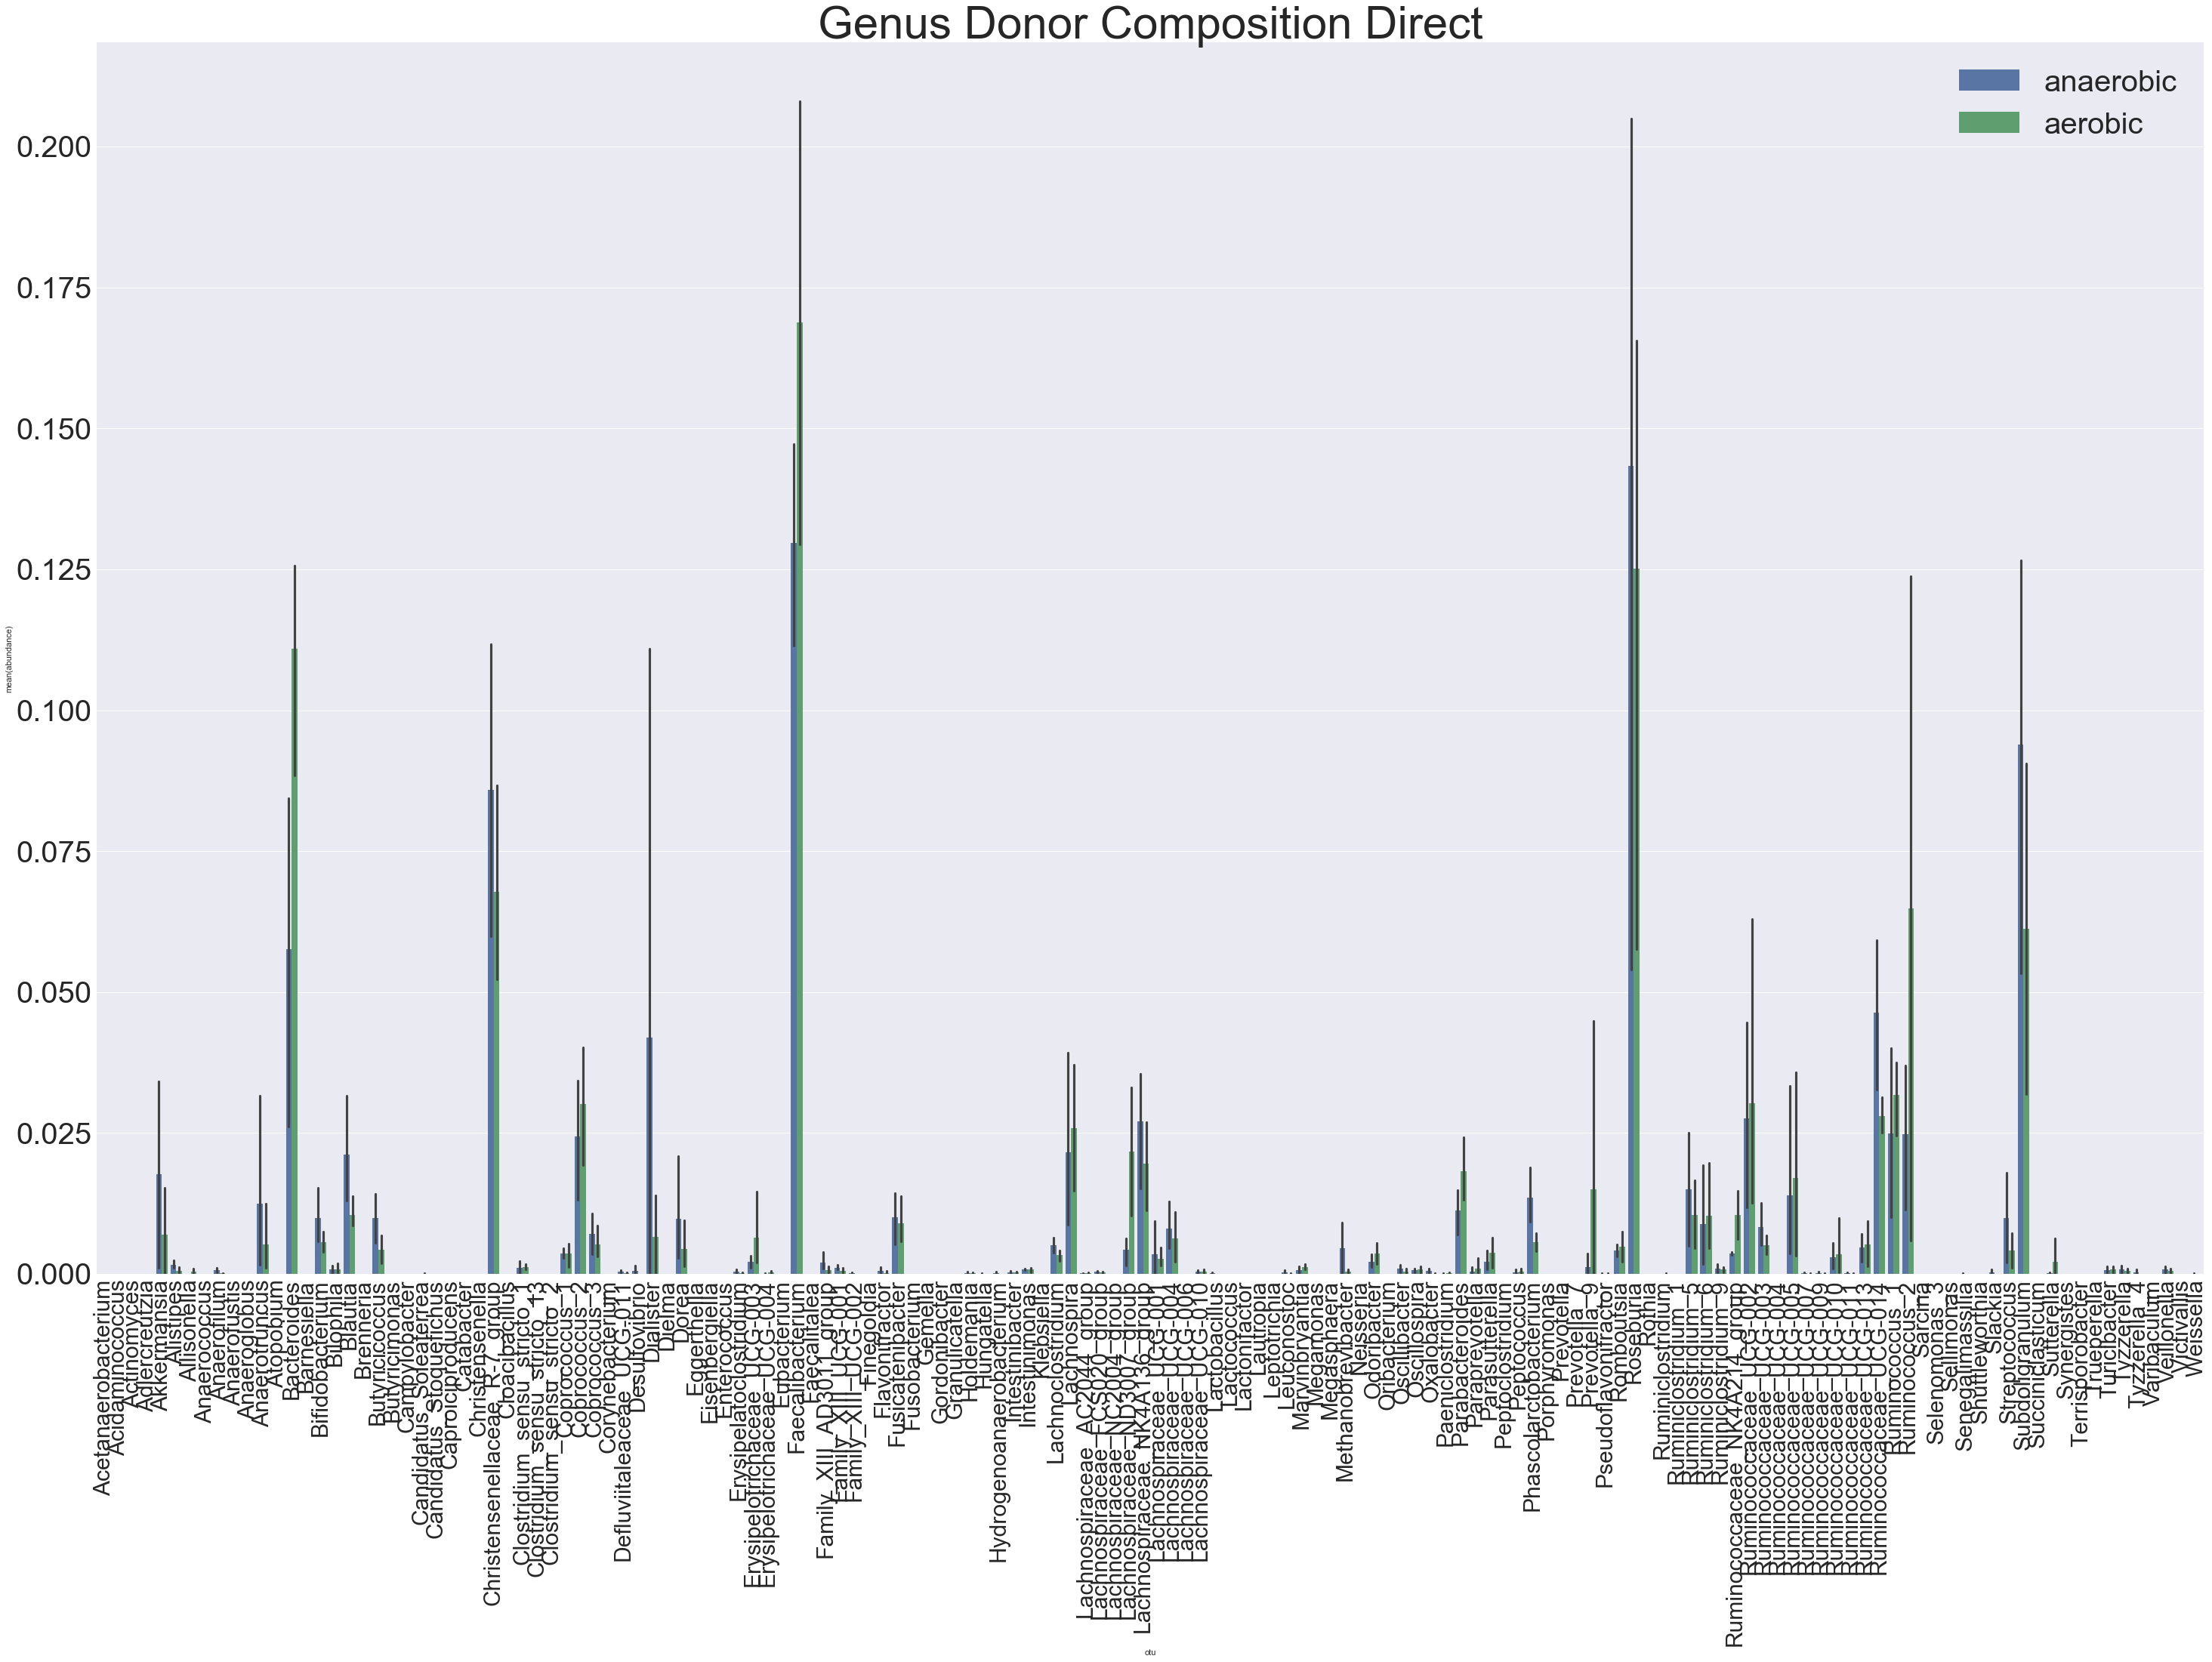

In [279]:
sns.barplot(x="otu", y="abundance", hue="aerobic", data=genus_donor_composition[genus_donor_composition["direct/pma"]=="direct"])
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=40)
plt.legend(fontsize=40)
plt.title("Genus Donor Composition Direct", fontsize=60)
plt.show()
plt.figure(figsize=(50,30))




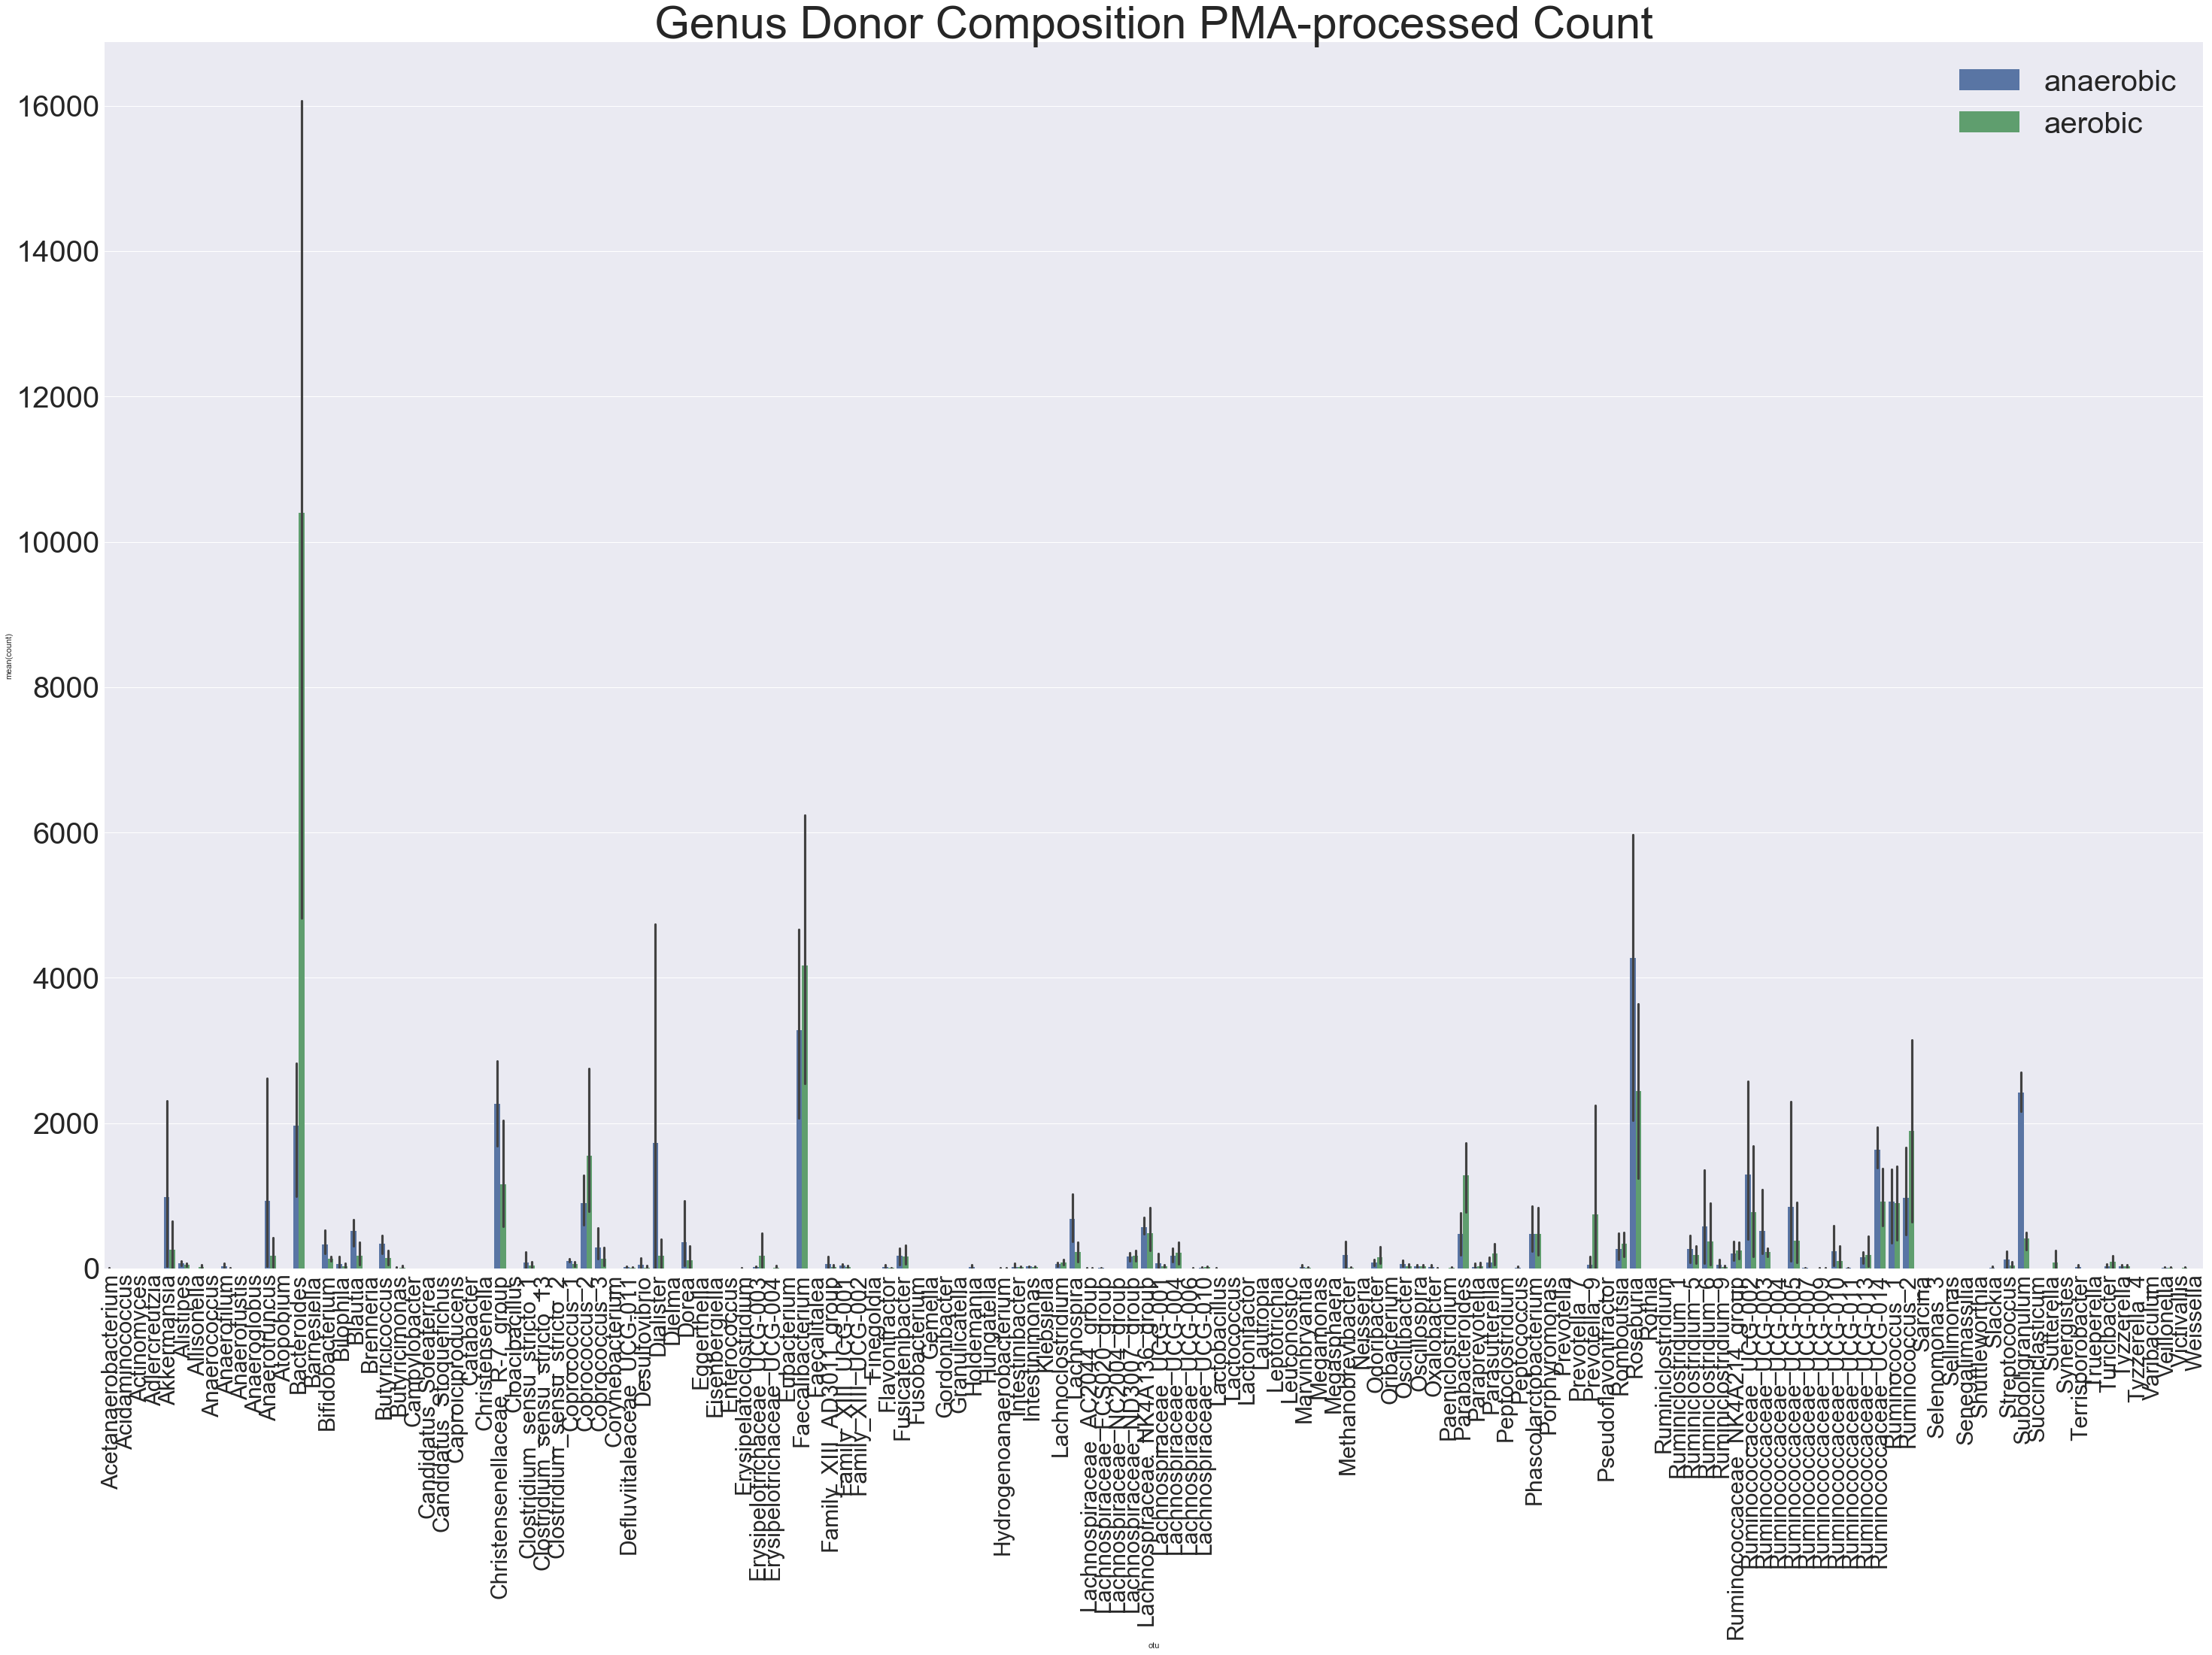

In [280]:
sns.barplot(x="otu", y="count", hue="aerobic", data=genus_donor_composition[genus_donor_composition["direct/pma"]=="pma"])
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=40)
plt.legend(fontsize=40)
plt.title("Genus Donor Composition PMA-processed Count", fontsize=60)
plt.show()
plt.figure(figsize=(50,30))




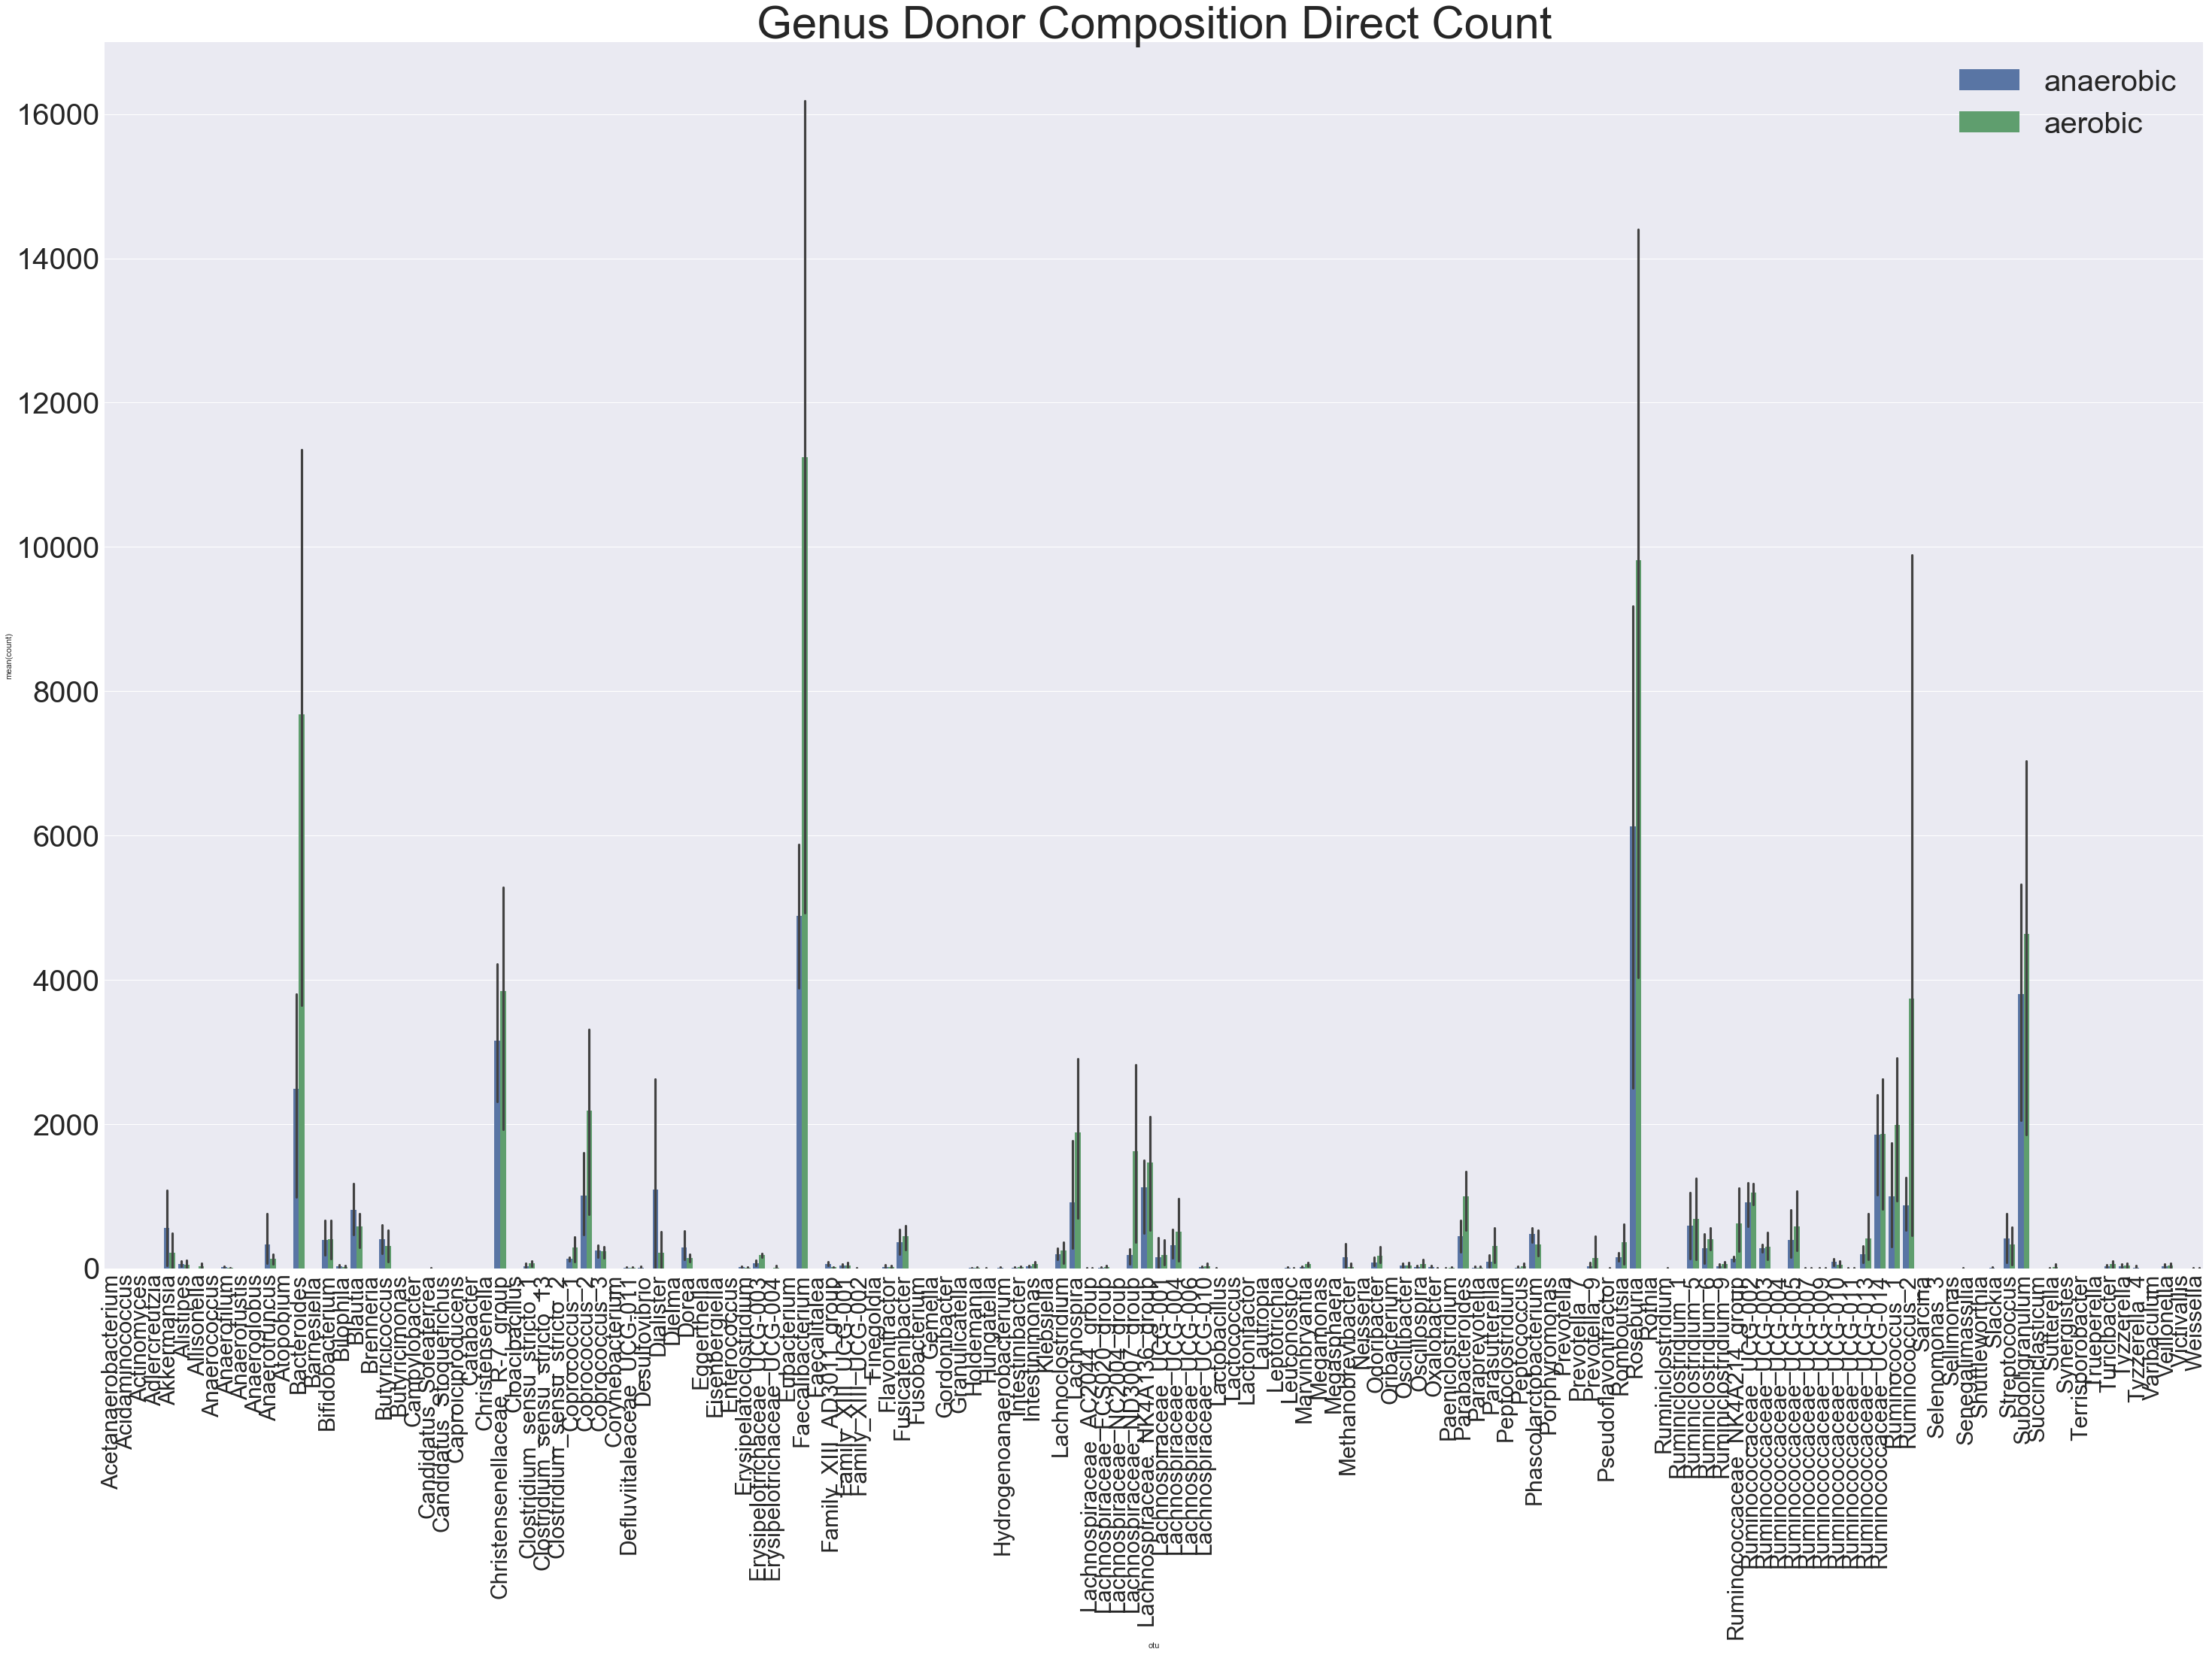

In [281]:
sns.barplot(x="otu", y="count", hue="aerobic", data=genus_donor_composition[genus_donor_composition["direct/pma"]=="direct"])
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=40)
plt.legend(fontsize=40)
plt.title("Genus Donor Composition Direct Count", fontsize=60)
plt.show()
plt.figure(figsize=(50,30))





In [282]:
genus_donor_composition_pma = genus_donor_composition[genus_donor_composition["direct/pma"]=="pma"]

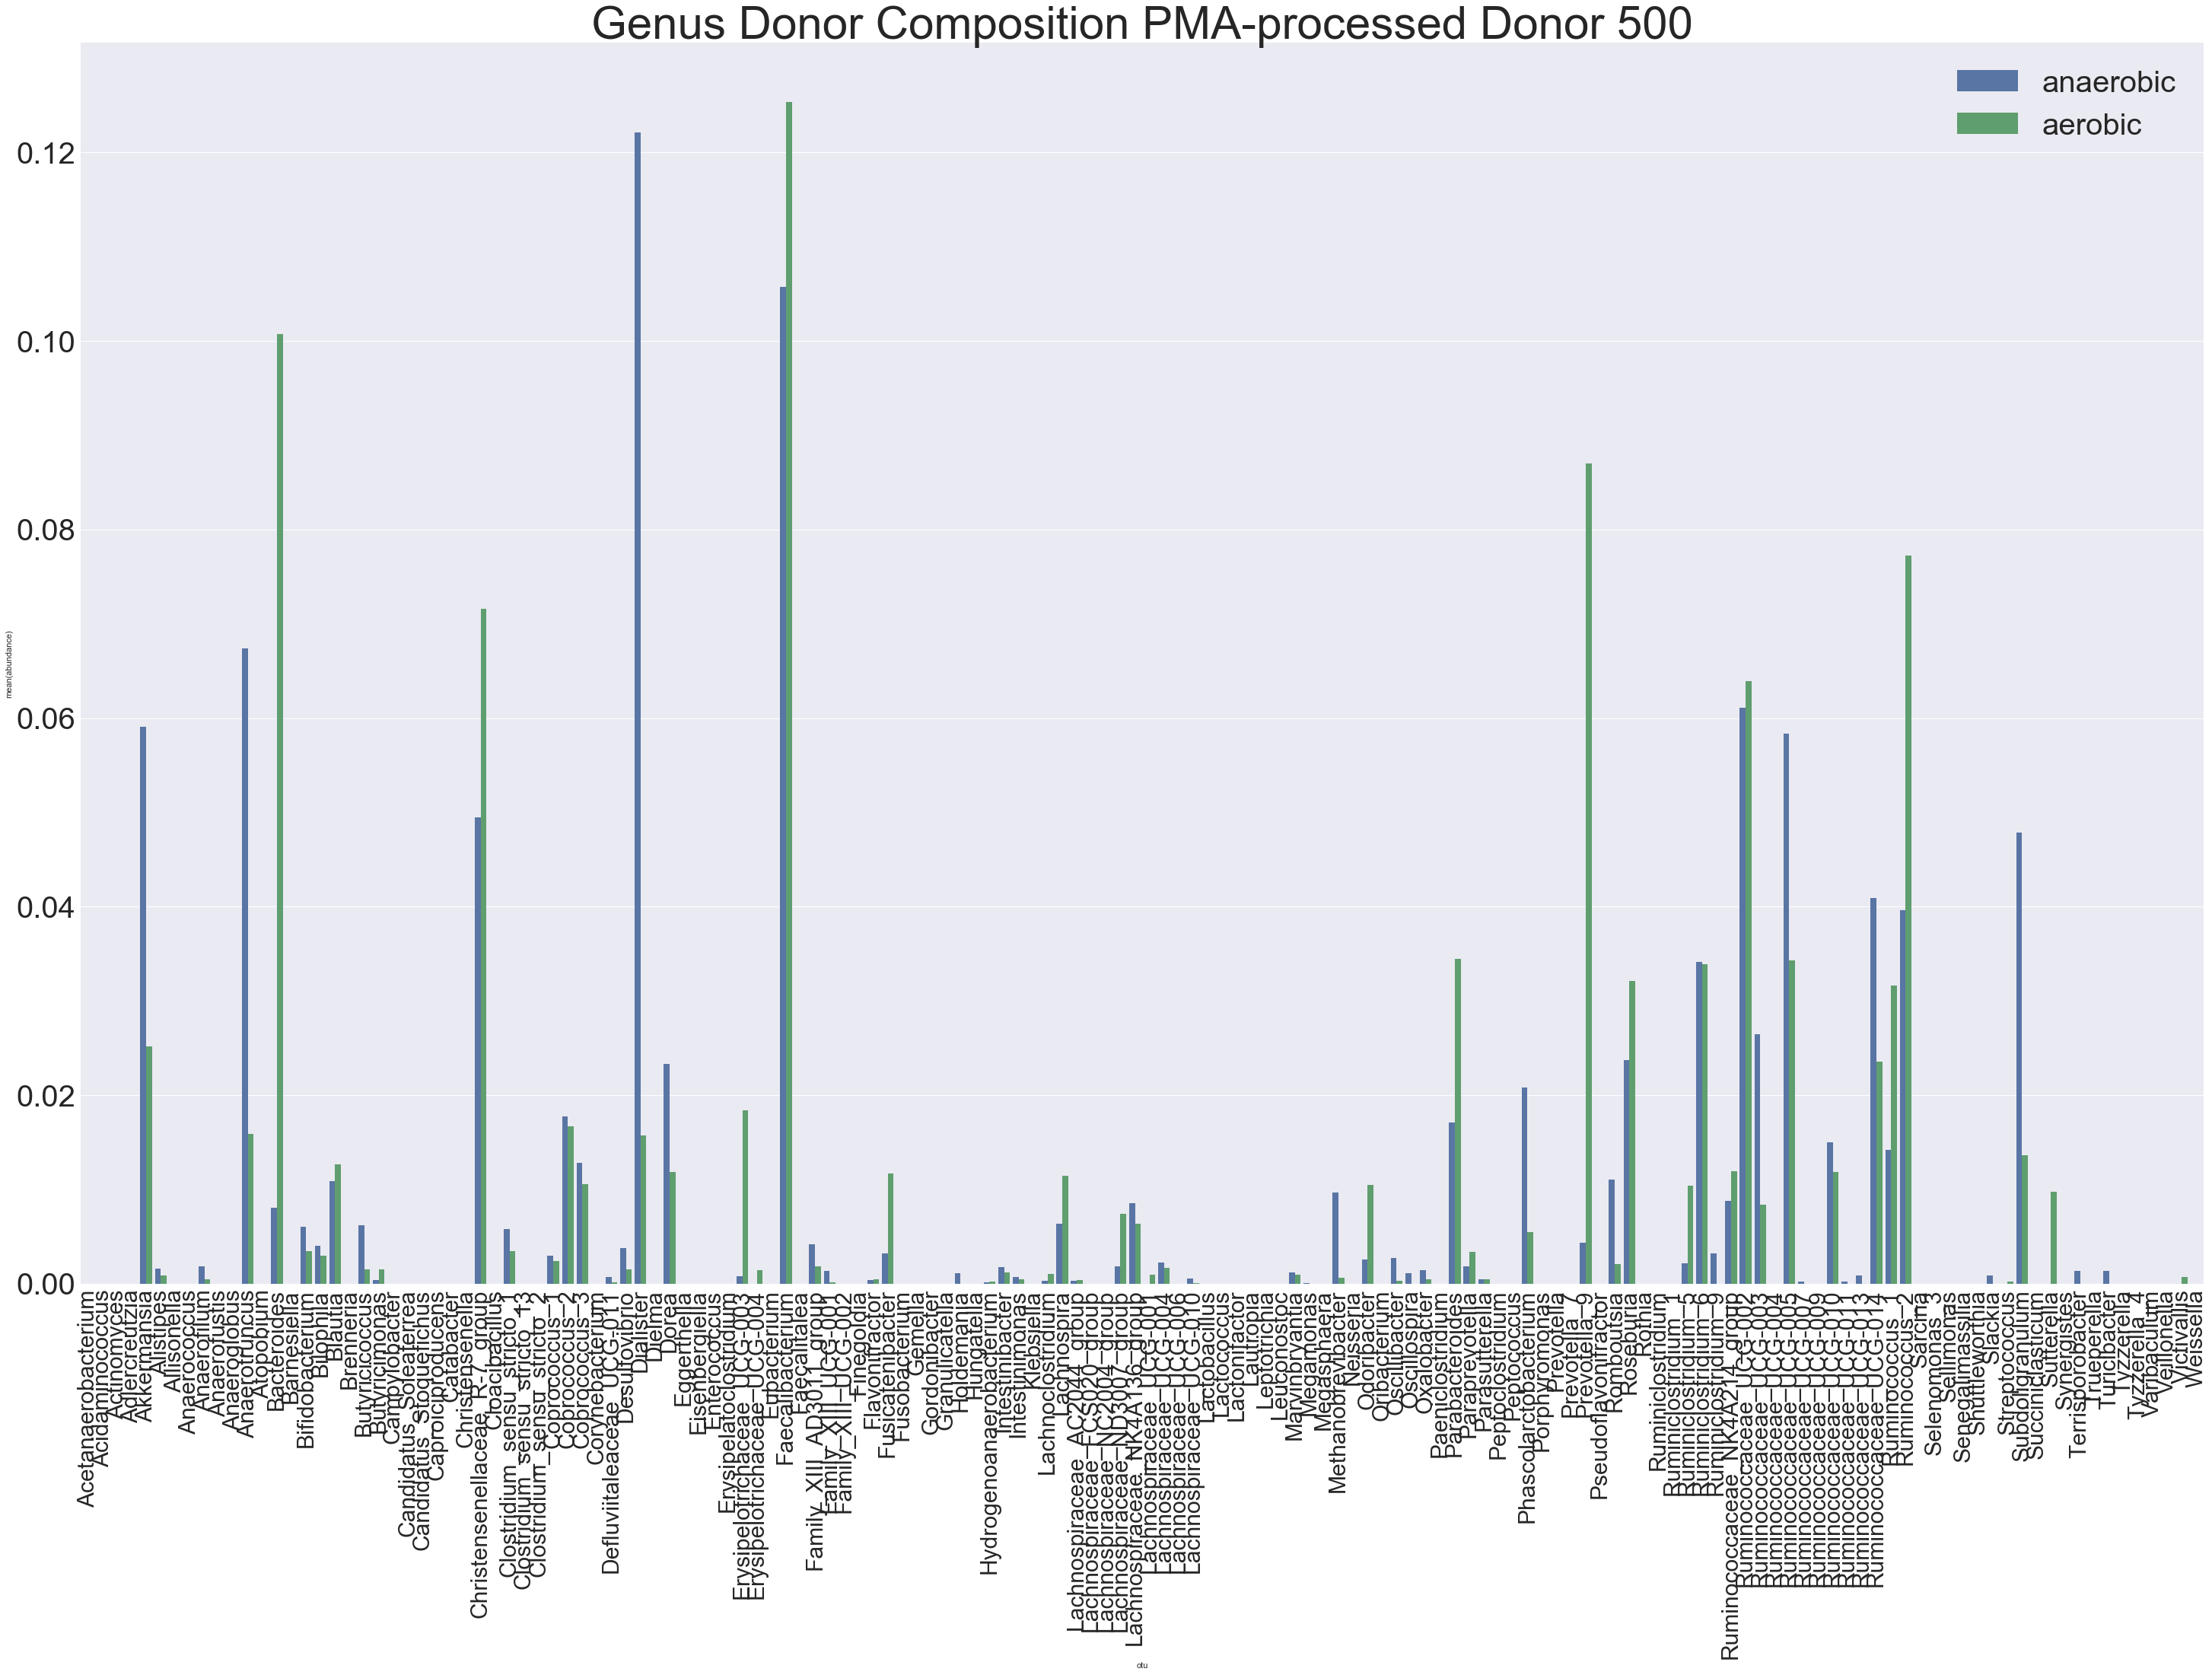

In [283]:
sns.barplot(x="otu", y="abundance", hue="aerobic", data=genus_donor_composition_pma[genus_donor_composition_pma["donor"]==500])
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=40)
plt.legend(fontsize=40)
plt.title("Genus Donor Composition PMA-processed Donor 500", fontsize=60)
plt.show()
plt.figure(figsize=(50,30))




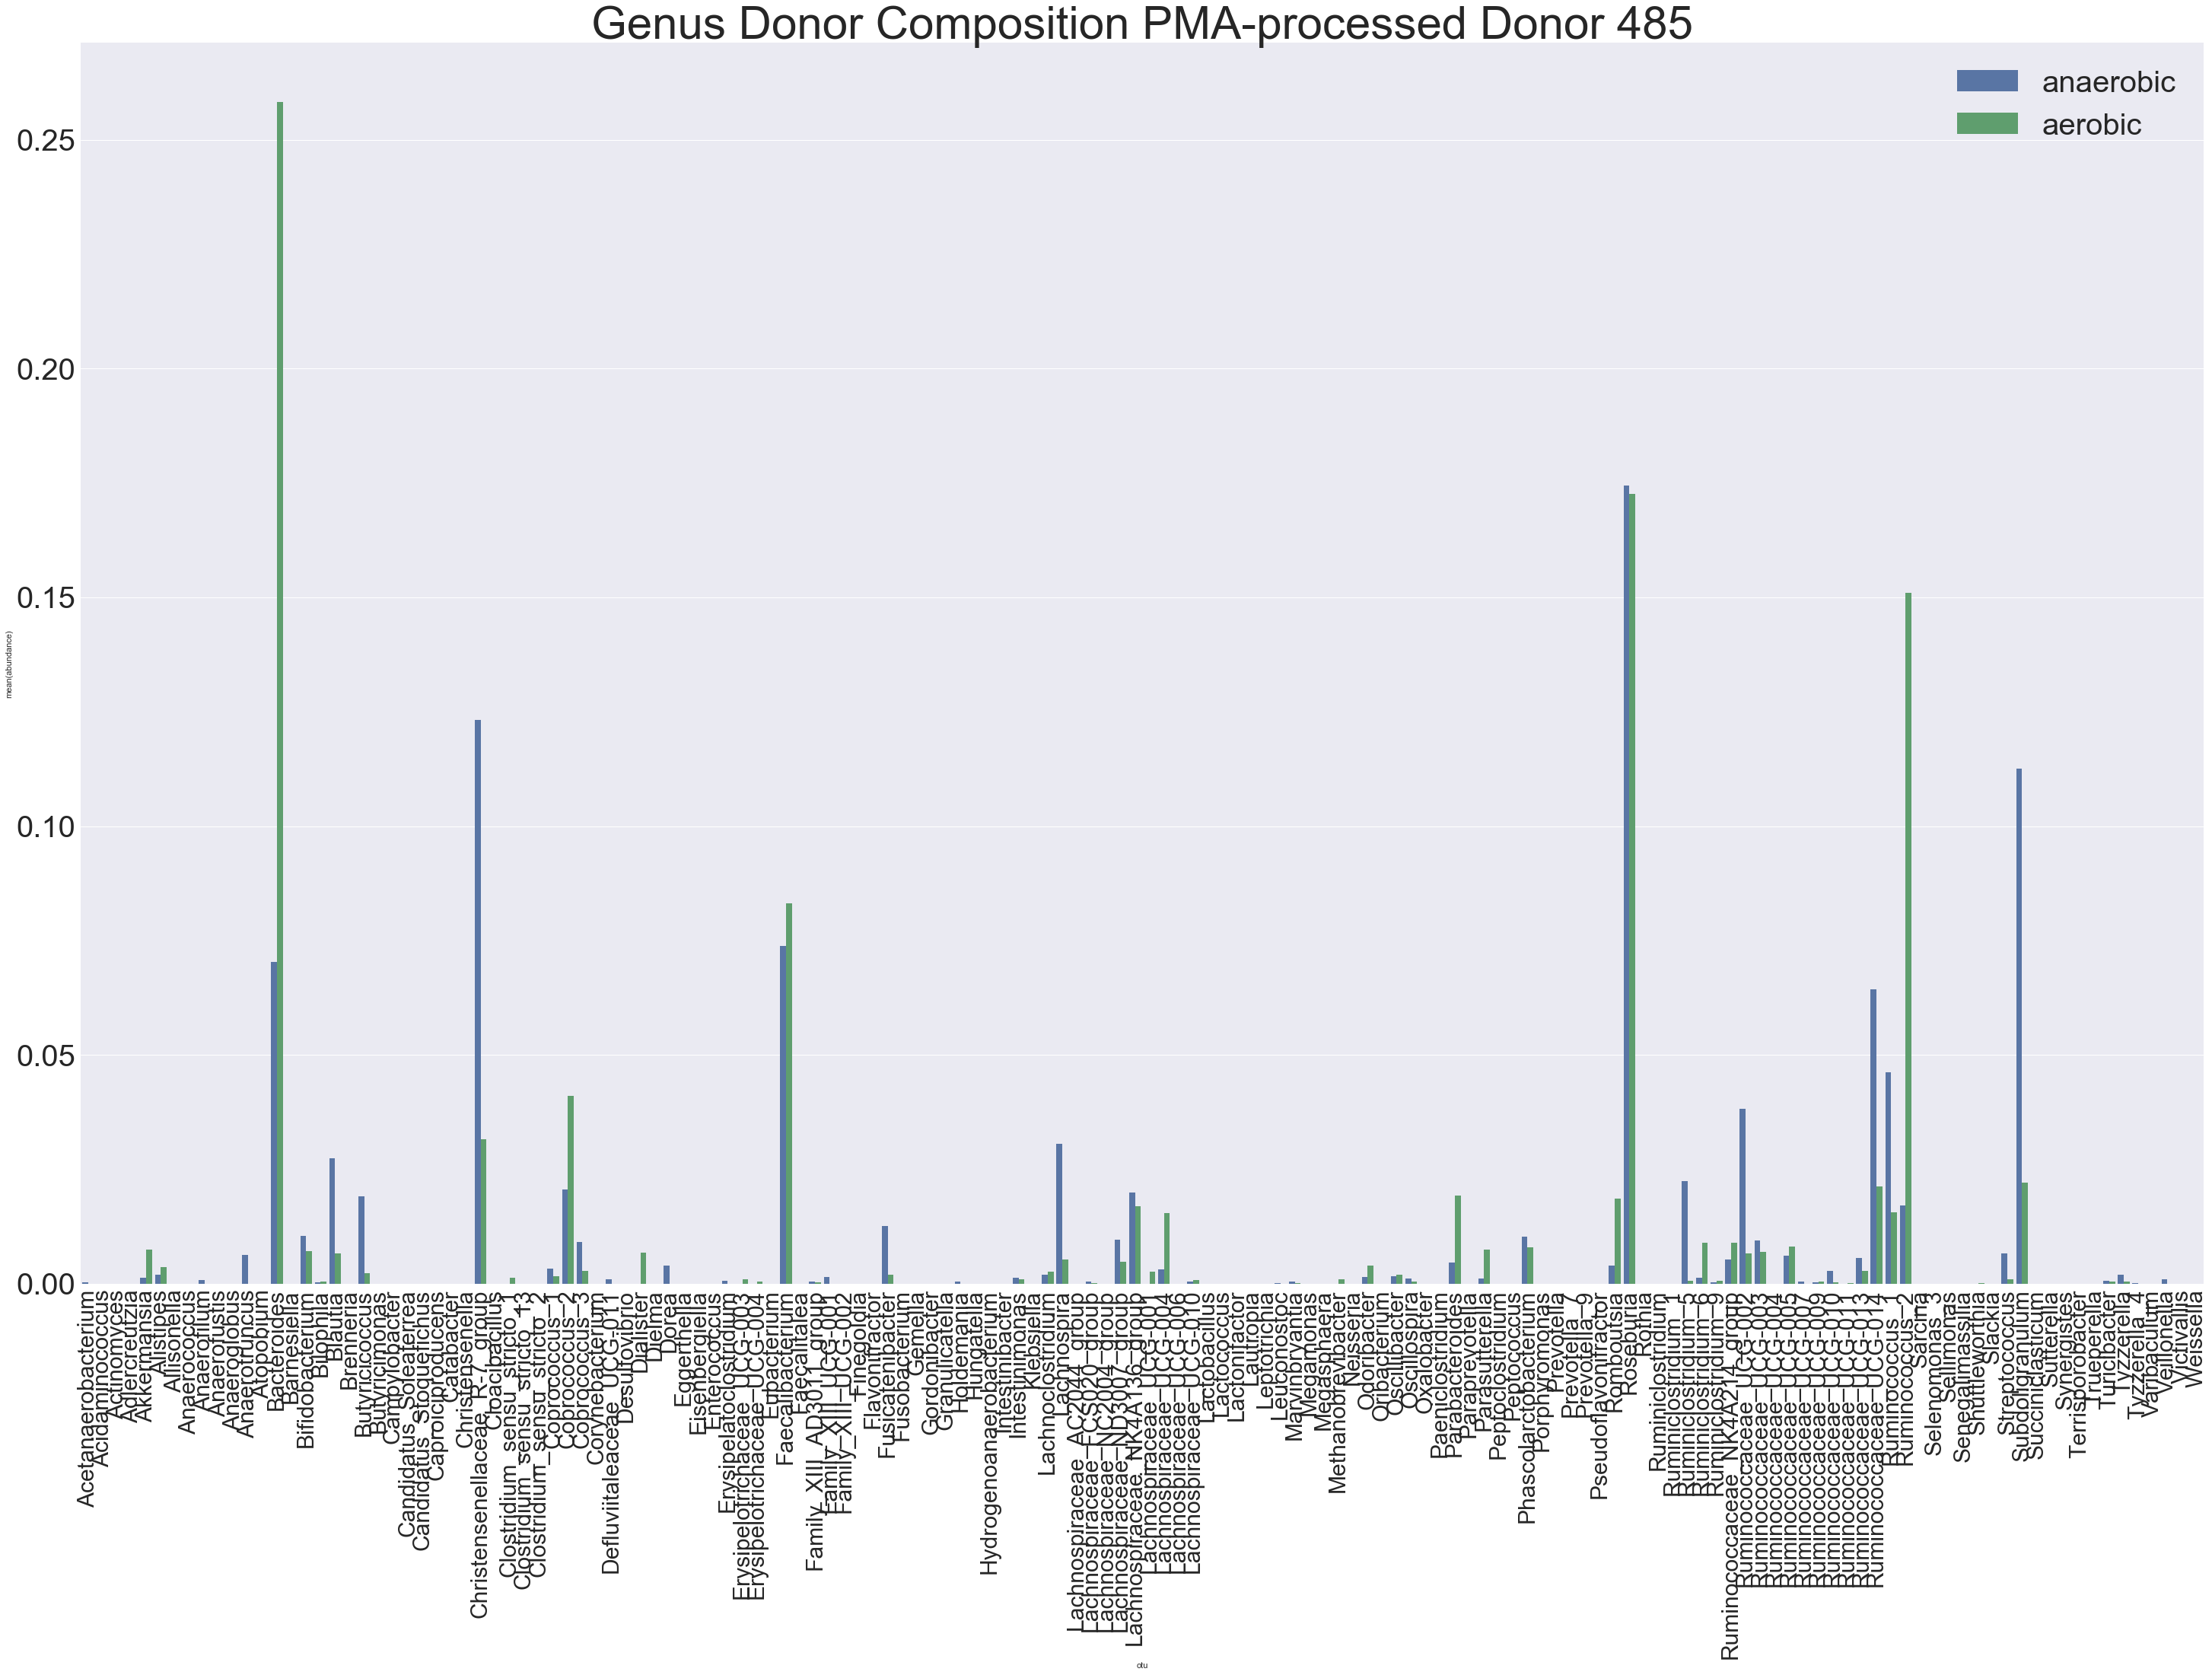

In [284]:
sns.barplot(x="otu", y="abundance", hue="aerobic", data=genus_donor_composition_pma[genus_donor_composition_pma["donor"]==485])
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=40)
plt.legend(fontsize=40)
plt.title("Genus Donor Composition PMA-processed Donor 485", fontsize=60)
plt.show()
plt.figure(figsize=(50,30))





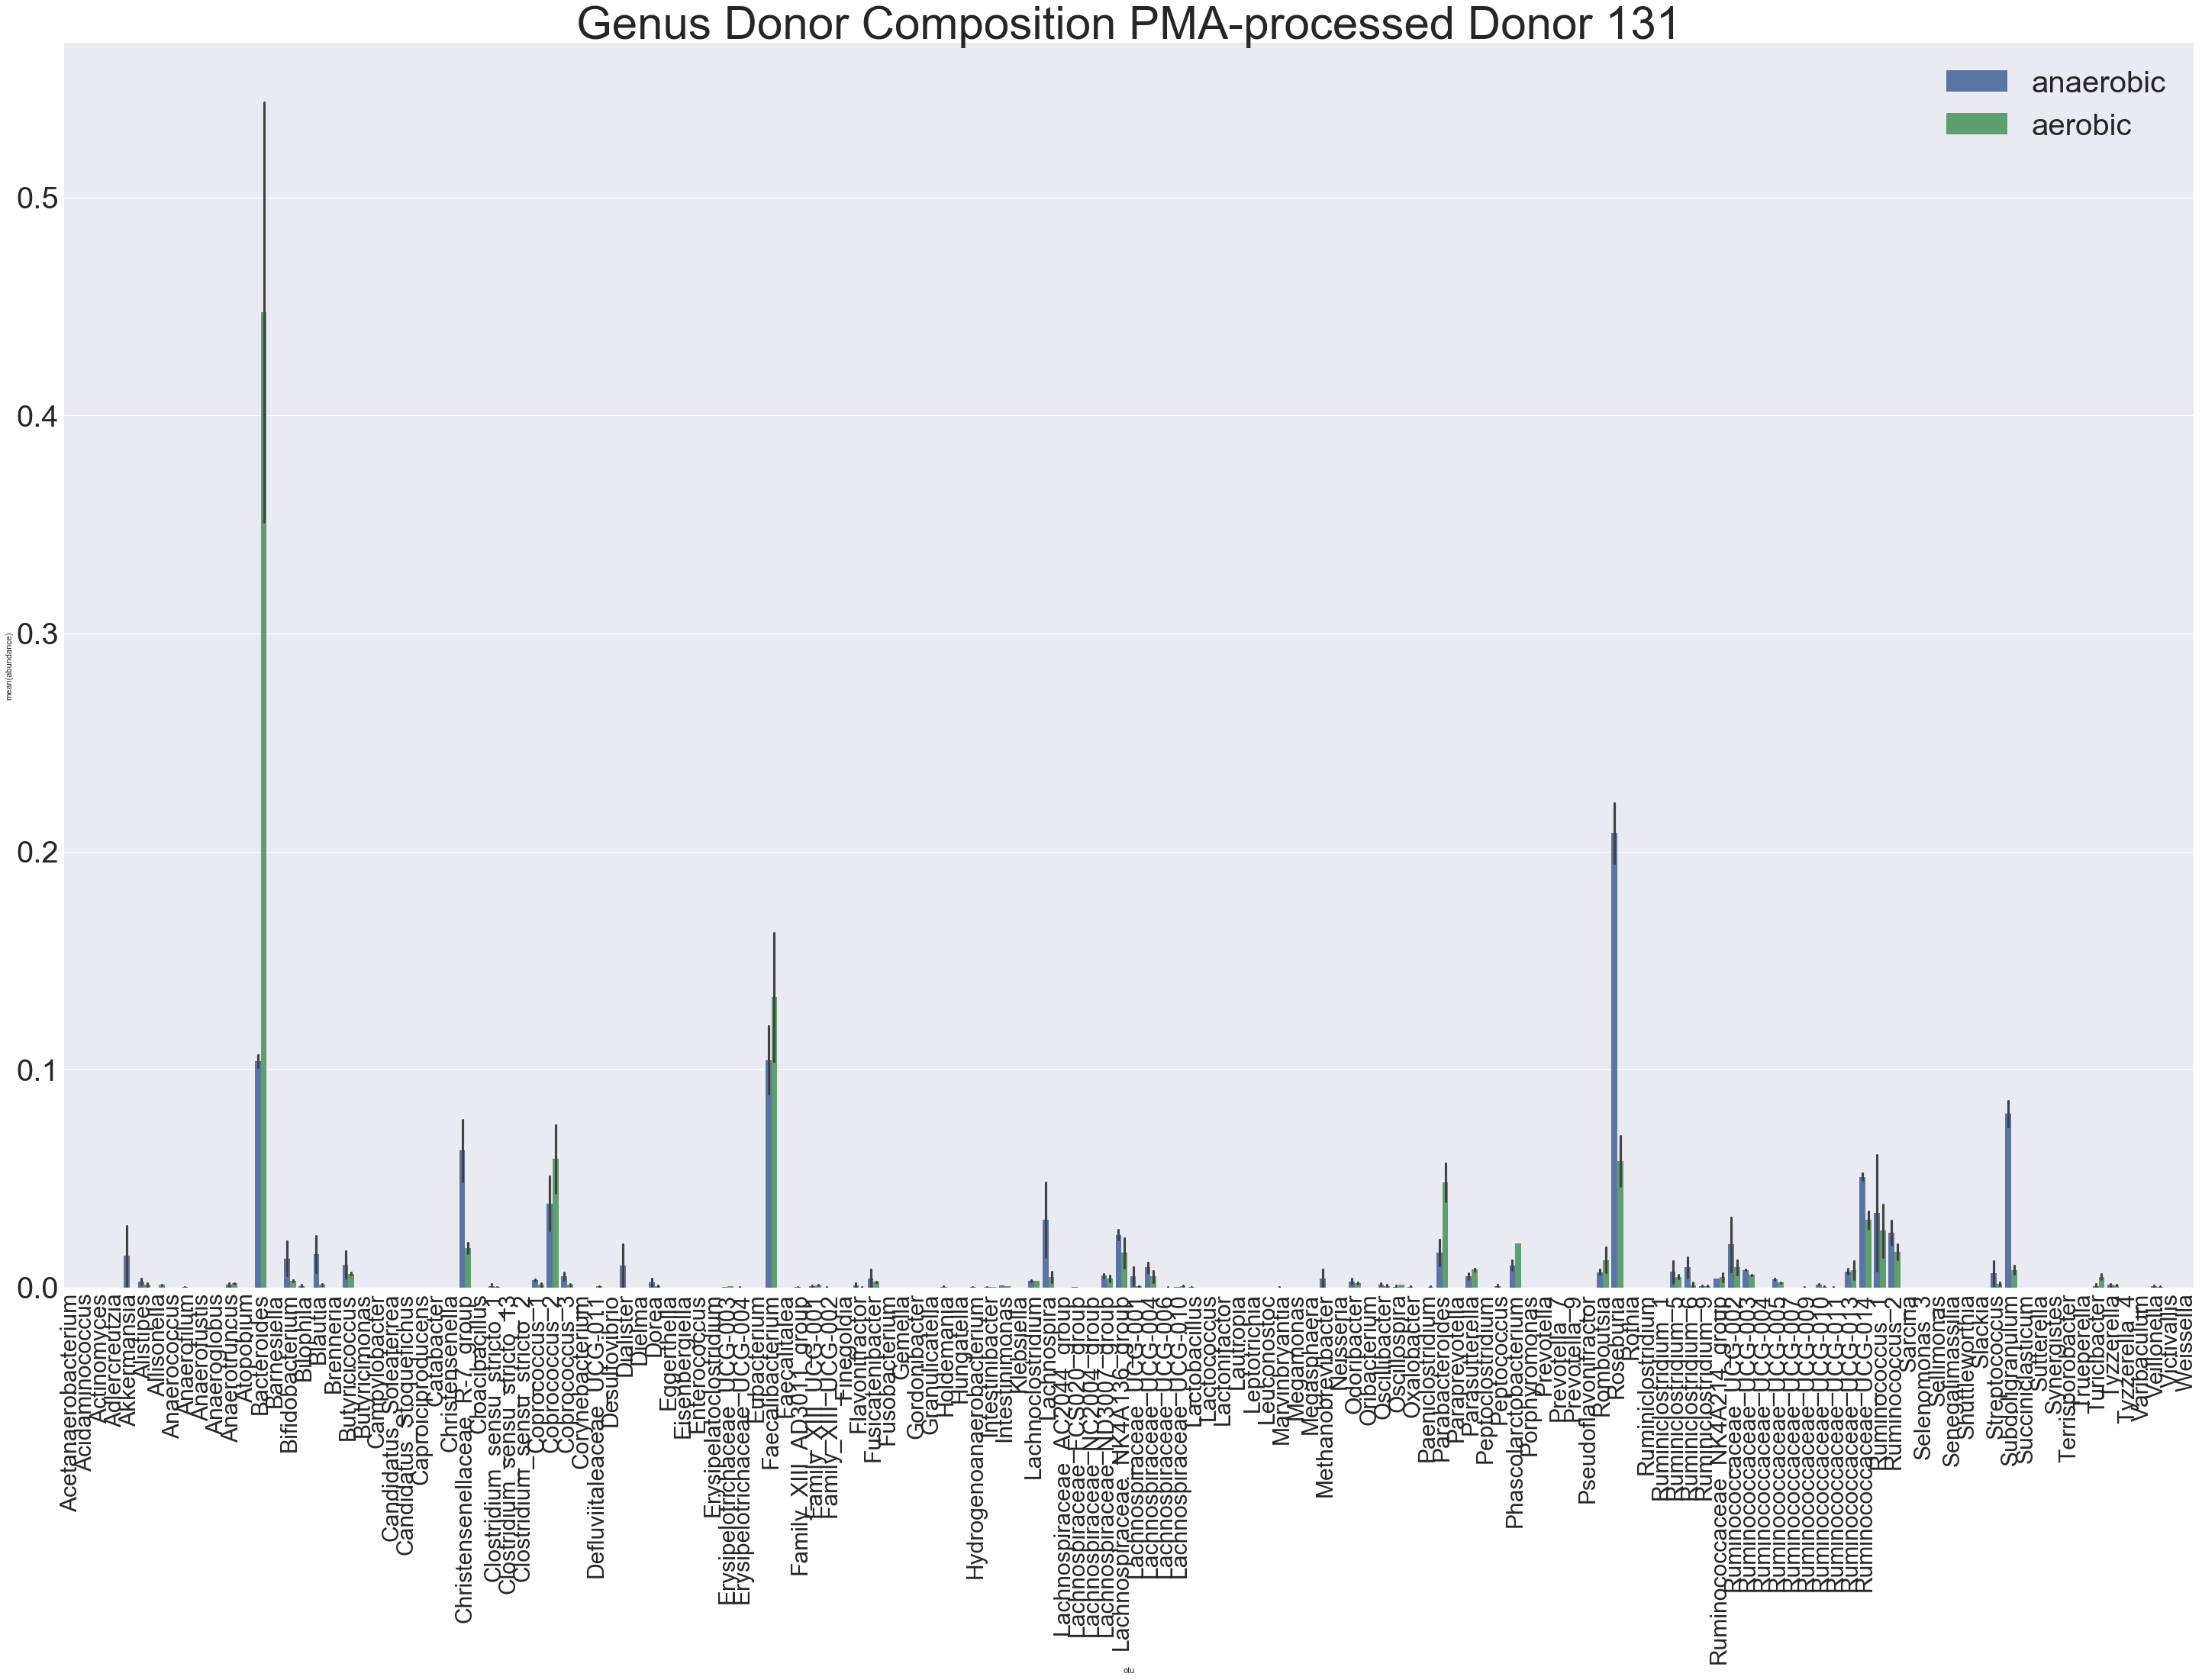

In [285]:
sns.barplot(x="otu", y="abundance", hue="aerobic", data=genus_donor_composition_pma[genus_donor_composition_pma["donor"]==131])
plt.xticks(rotation=90, fontsize=30)
plt.yticks(fontsize=40)
plt.legend(fontsize=40)
plt.title("Genus Donor Composition PMA-processed Donor 131", fontsize=60)
plt.show()
plt.figure(figsize=(50,30))





### Donor vs. Recipient Composition Time Series

In [355]:
def composition_by_source(otu_table_counts, otu_table_abundance, metadata, pdf):
    composition_summary_df = pd.DataFrame(columns=["patient", "direct/pma", "donor_abundance", "both_abundance", "patient_abundance", "other", "aerobic", "timepoint"])
    with PdfPages(pdf) as pp:
        donor_only = {} #dict where keys are patient ids and values are lists of indices representing seq vars that are in 
                    #the corresponding donor but not in the patient originally, where the first list is direct and the second pma 
        for i in otu_table_counts.index:
            if metadata.loc[i, "timepoint"] == "Pre-FMT":
                donor_only[metadata.loc[i, "person_id"]] = [list(set(list(otu_table_counts.loc[metadata.loc[i, "direct_donor_fmt_id"]].nonzero()[0]))-set(list(otu_table_counts.loc[i].nonzero()[0]))),list(set(list(otu_table_counts.loc[metadata.loc[i, "pma_donor_fmt_id"]].nonzero()[0]))-set(list(otu_table_counts.loc[i].nonzero()[0])))]
        both = {}
        for i in otu_table_counts.index:
            if metadata.loc[i, "timepoint"] == "Pre-FMT":
                both[metadata.loc[i, "person_id"]] = [list(set(list(otu_table_counts.loc[metadata.loc[i, "direct_donor_fmt_id"]].nonzero()[0]))&set(list(otu_table_counts.loc[i].nonzero()[0]))),list(set(list(otu_table_counts.loc[metadata.loc[i, "pma_donor_fmt_id"]].nonzero()[0]))&set(list(otu_table_counts.loc[i].nonzero()[0])))]
        patient_only = {}
        for i in otu_table_counts.index:
            if metadata.loc[i, "timepoint"] == "Pre-FMT":
                patient_only[metadata.loc[i, "person_id"]] = [list(set(list(otu_table_counts.loc[i].nonzero()[0]))-set(list(otu_table_counts.loc[metadata.loc[i, "direct_donor_fmt_id"]].nonzero()[0]))),list(set(list(otu_table_counts.loc[i].nonzero()[0]))-set(list(otu_table_counts.loc[metadata.loc[i, "pma_donor_fmt_id"]].nonzero()[0])))]
      
        for patient in donor_only.keys():
            
            composition_dict = OrderedDict()
            for i, timepoint in enumerate(["Pre-FMT", "3 days", "10 days", "4 weeks", "8 weeks"]):
                try:
                    sample_id = metadata.index[(metadata["person_id"] == patient) & (metadata["timepoint"] == timepoint)][0]


                    aerobic = metadata.loc[sample_id, "anaerobic_fmt"]
                    donor_abundance = 0
                    both_abundance = 0
                    patient_abundance = 0 
                    #just for PMA samples
                    for d in donor_only[patient][1]:
                        donor_abundance += otu_table_abundance.loc[sample_id, otu_table_counts.columns[d]]
                    for b in both[patient][1]:
                        both_abundance += otu_table_abundance.loc[sample_id, otu_table_counts.columns[b]]
                    for p in patient_only[patient][1]:
                        patient_abundance += otu_table_abundance.loc[sample_id, otu_table_counts.columns[p]]  
                    other = 1-(donor_abundance+both_abundance+patient_abundance)
                    composition_dict[timepoint] = [donor_abundance, both_abundance, patient_abundance, other]
                    
                    composition_summary_df = composition_summary_df.append({"patient":patient,"direct/pma":"pma", "donor_abundance":donor_abundance, "both_abundance":both_abundance, "patient_abundance":patient_abundance, "other":other,"aerobic":aerobic, "timepoint":timepoint}, ignore_index=True)
                    donor_abundance = 0
                    both_abundance = 0
                    patient_abundance = 0 
                    for d in donor_only[patient][0]:
                        donor_abundance += otu_table_abundance.loc[sample_id, otu_table_counts.columns[d]]
                    for b in both[patient][0]:
                        both_abundance += otu_table_abundance.loc[sample_id, otu_table_counts.columns[b]]
                    for p in patient_only[patient][0]:
                        patient_abundance += otu_table_abundance.loc[sample_id, otu_table_counts.columns[p]]  
                    other = 1-(donor_abundance+both_abundance+patient_abundance)
                    composition_dict[timepoint] = [donor_abundance, both_abundance, patient_abundance, other]
                    
                    composition_summary_df = composition_summary_df.append({"patient":patient,"direct/pma":"direct", "donor_abundance":donor_abundance, "both_abundance":both_abundance, "patient_abundance":patient_abundance, "other":other,"aerobic":aerobic, "timepoint":timepoint}, ignore_index=True)
                    
                except Exception as e:
                    print(e)
            composition_df_dict = pd.DataFrame.from_dict(composition_dict, orient="index")
            composition_df_dict.columns = ["donor_abundance", "both_abundance", "patient_abundance", "other"]
            composition_df_dict.plot(kind="bar",stacked=True)
            plt.title("Patient: {} Donor: {} {}".format(patient, int(metadata.loc[sample_id,"donor_fmt_num"]), aerobic))
            pp.savefig()
        #print(donor_only)
            
        return composition_summary_df



In [357]:
seq_var_composition = composition_by_source(seq_freq_filtered_by_patient, seq_freq_filtered_by_patient_abundance, metadata, "seq_var_composition_timeseries.pdf")

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


In [358]:
seq_var_composition_pma = seq_var_composition[seq_var_composition["direct/pma"] == "pma"].drop(["direct/pma"], axis=1)
seq_var_composition_direct = seq_var_composition[seq_var_composition["direct/pma"] == "direct"].drop(["direct/pma"], axis=1)
seq_var_composition_direct_grouped = seq_var_composition_direct.groupby(["aerobic", "timepoint"]).mean().reset_index()
seq_var_composition_pma_grouped = seq_var_composition_pma.groupby(["aerobic", "timepoint"]).mean().reset_index()

In [359]:
seq_var_composition_pma_grouped_aerobic = seq_var_composition_pma_grouped[seq_var_composition_pma_grouped["aerobic"]=="Aerobic"]
seq_var_composition_pma_grouped_anaerobic = seq_var_composition_pma_grouped[seq_var_composition_pma_grouped["aerobic"]=="Anaerobic"]
seq_var_composition_pma_grouped_anaerobic = seq_var_composition_pma_grouped_anaerobic.set_index("timepoint").reindex(["Pre-FMT","3 days", "10 days", "4 weeks", "8 weeks"])
seq_var_composition_pma_grouped_aerobic = seq_var_composition_pma_grouped_aerobic.set_index("timepoint").reindex(["Pre-FMT","3 days", "10 days", "4 weeks", "8 weeks"])

In [362]:
seq_var_composition_direct_grouped_aerobic = seq_var_composition_direct_grouped[seq_var_composition_direct_grouped["aerobic"]=="Aerobic"]
seq_var_composition_direct_grouped_anaerobic = seq_var_composition_direct_grouped[seq_var_composition_direct_grouped["aerobic"]=="Anaerobic"]
seq_var_composition_direct_grouped_anaerobic = seq_var_composition_direct_grouped_anaerobic.set_index("timepoint").reindex(["Pre-FMT","3 days", "10 days", "4 weeks", "8 weeks"])
seq_var_composition_direct_grouped_aerobic = seq_var_composition_direct_grouped_aerobic.set_index("timepoint").reindex(["Pre-FMT","3 days", "10 days", "4 weeks", "8 weeks"])

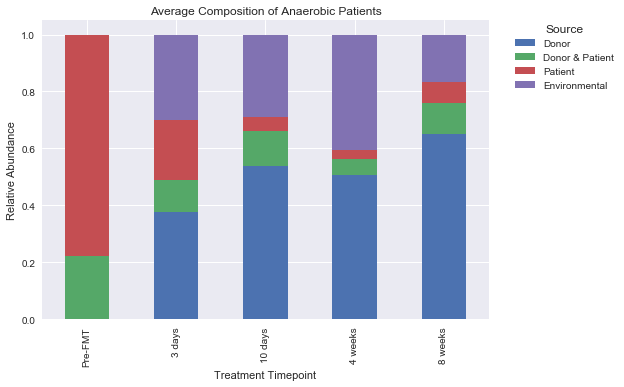

In [382]:
ax = seq_var_composition_pma_grouped_anaerobic.plot(kind="bar", stacked=True)
plt.ylabel("Relative Abundance")
plt.xlabel("Treatment Timepoint")
ax.legend(title = "Source", labels = ['Donor', 'Donor & Patient', 'Patient', 'Environmental'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Average Composition of Anaerobic Patients")
plt.show()

In [ ]:
ax = seq_var_composition_pma_grouped_aerobic.plot(kind="bar", stacked=True)
plt.ylabel("Relative Abundance")
plt.xlabel("Treatment Timepoint")
ax.legend(title = "Source", labels = ['Donor', 'Donor & Patient', 'Patient', 'Environmental'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Average Composition of Aerobic Patients")
plt.show()

In [ ]:
ax = sns.boxplot(x="timepoint", y="donor_abundance", hue="aerobic", data=seq_var_composition_direct)
plt.legend(title="")
plt.show()

In [ ]:
donor1=[] #500 - An:143, A:146
donor2=[] #485 - An:141, 159, A:176
donor3=[] #131 - An: 140, 167, A: 154, 160, 163, 178

engraftment_summary_df = pd.DataFrame(columns=["timepoint", "direct/pma", "count", "freq","abundance", "aerobic"])
with PdfPages("engraftment_timeseries.pdf") as pp:
    for patient, donor_seqs in seq_var_dict.items():
        donor_seqs.append(set(donor_seqs[0])-set(donor_seqs[1]))
        engraftment_df = pd.DataFrame(columns=["timepoint", "direct/pma", "count", "freq","abundance"])
        for i, timepoint in enumerate(["3 days", "10 days", "4 weeks", "8 weeks"]):  
            try:

                #sample_id of sample corresponding to the given patient and timepoint
                sample_id = metadata.index[(metadata["person_id"] == patient) & (metadata["timepoint"] == timepoint)][0]
                #list of indices of seq vars from direct and pma-processed donor samples that also show up in patient at different timepoints

#                 direct = list(set(donor_seqs[0]) & set(list(seq_freq_filtered_by_patient.loc[sample_id].nonzero()[0])))
#                 pma = list(set(donor_seqs[1]) & set(list(seq_freq_filtered_by_patient.loc[sample_id].nonzero()[0])))
#                 direct_pma = list(set(donor_seqs[2]) & set(list(seq_freq_filtered_by_patient.loc[sample_id].nonzero()[0])))
                
                direct = list(set(donor_seqs[0]) & set(seq_freq_filtered_by_patient.loc[sample_id]))
                pma = list(set(donor_seqs[1]) & set(seq_freq_filtered_by_patient.loc[sample_id]))
                direct_pma = list(set(donor_seqs[2]) & set(seq_freq_filtered_by_patient.loc[sample_id]))
 
                direct_abundance = 0
                pma_abundance = 0
                direct_pma_abundance = 0
                
                for d in direct:
                    direct_abundance += seq_freq_filtered_by_patient_abundance.loc[sample_id,seq_freq_filtered_by_patient_abundance.columns[d]]
                for p in pma:
                    pma_abundance += seq_freq_filtered_by_patient_abundance.loc[sample_id,seq_freq_filtered_by_patient.columns[p]]    
                for dp in direct_pma:
                    direct_pma_abundance += seq_freq_filtered_by_patient_abundance.loc[sample_id,seq_freq_filtered_by_patient.columns[dp]]  
                aerobic = metadata.loc[sample_id, "anaerobic_fmt"]
                engraftment_df = engraftment_df.append({"timepoint":timepoint, "direct/pma":"direct", "count":len(direct), "freq":len(direct)/num_patient_seq_var, "abundance":direct_abundance}, ignore_index=True)
                engraftment_df = engraftment_df.append({"timepoint":timepoint, "direct/pma":"pma", "count":len(pma), "freq":len(pma)/num_patient_seq_var, "abundance":pma_abundance}, ignore_index=True)
                engraftment_df = engraftment_df.append({"timepoint":timepoint, "direct/pma":"direct-pma", "count":len(direct_pma), "freq":len(direct_pma)/num_patient_seq_var, "abundance":direct_pma_abundance}, ignore_index=True)
                engraftment_summary_df = engraftment_summary_df.append({"timepoint":timepoint, "direct/pma":"direct", "count":len(direct), "freq":len(direct)/num_patient_seq_var, "abundance":direct_abundance, "aerobic":aerobic}, ignore_index=True)
                engraftment_summary_df = engraftment_summary_df.append({"timepoint":timepoint, "direct/pma":"pma", "count":len(pma), "freq":len(pma)/num_patient_seq_var, "abundance":pma_abundance,"aerobic":aerobic}, ignore_index=True)
                

            #missing timepoints
            except Exception as e:
                print(e)
        if metadata.loc[sample_id, "donor_fmt_num"] == 500:
            donor1.append([engraftment_df, int(patient), metadata.loc[sample_id,"anaerobic_fmt"]])
        elif metadata.loc[sample_id, "donor_fmt_num"] == 485:
            donor2.append([engraftment_df, int(patient), metadata.loc[sample_id,"anaerobic_fmt"]])
        else:
            donor3.append([engraftment_df, int(patient), metadata.loc[sample_id,"anaerobic_fmt"]])
        ax1 = sns.barplot(x="timepoint", y="count", hue="direct/pma",data = engraftment_df)
        ax1.set_title("Patient: {} Donor: {} {}".format(int(patient), int(metadata.loc[sample_id,"donor_fmt_num"]), metadata.loc[sample_id,"anaerobic_fmt"]))
        ax1.set_ylabel("total # donor seq vars in patient")
        pp.savefig()
        plt.close()
        
        ax2 = sns.barplot(x="timepoint", y="abundance", hue="direct/pma",data = engraftment_df)
        ax2.set_title("Patient: {} Donor: {} {}".format(int(patient), int(metadata.loc[sample_id,"donor_fmt_num"]), metadata.loc[sample_id,"anaerobic_fmt"]))
        ax2.set_ylabel("total relative abundance of donor seq vars in patient")
        pp.savefig()
        plt.close()




In [391]:
genus_composition = composition_by_source(genus, genus_abundance, metadata, "genus_composition_timeseries.pdf")

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


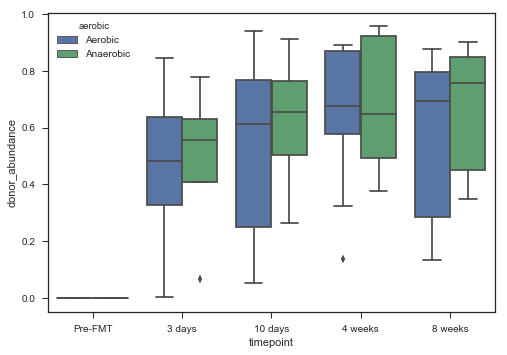

In [394]:
sns.boxplot(x="timepoint", y="donor_abundance", hue="aerobic", data=genus_composition)
plt.show()

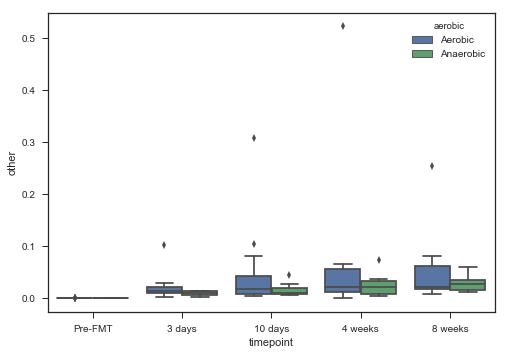

In [393]:
sns.boxplot(x="timepoint", y="other", hue="aerobic", data=genus_composition)
plt.show()